_putting here some core parts of the code I used in the experiment in my master's degree thesis. this is not an end-to-end code, and __BY NO MEANS is an example of a good code__, since it's my very first attemt at programming, but it does the job. it's more like notes and ideas rather than a complete solution._ 

### I advise against using the following code for anything other than continuing to do experiments to solve the problems that I outlined below.

<hr>

<center> <h1>The use of DNN as a tool to evaluate Mandarin pronunciation for CFL speakers</h1></center>

## The main goal of the experiment:

 - Explore the possibility of use of a deep neural networks (trained on a standard Mandarin audio courpus using supervised learning) as a tool to evaluate the quality of Mandarin tone pronunciation of second language learners, so the probability estimate of class prediction would reflect the test subject's quality of tone pronunciation. NOTE: This is different from the usual goal of such models, which strive for _high confidence tone detection_

## General steps:

- combine Tone Perfect dataset entries with 普通话测试 dataset (single syllable entries) to form a dataset
- explore and balance the training data
- engineer features (MFCC-based) that reflect four different tones of Mandarin Chinese
- train a CNN model(s) on it so that __probability estimate of class prediction would reflect the test subject's quality of tone pronunciation__
- evaluate model performance on the test set of the dataset __as well as on the data outside of the corpus__, and analyze the results

<hr>

<center> <h1>Final report:</h1></center>



I used two fully annotated Mandarin corpuses. One is Tone Perfect dataset (kindly provided by Catherine Ryu, Mandarin Tone Perception & Production Team, and Michigan State University Libraries, https://tone.lib.msu.edu/), all of the ~9000 entries were used. The other one is 普通话测试朗读词语表 part consisting ~16000 entries (of which only ~3000 单音节语音 were used) of a semi-publicly available Mandarin standard pronunciation exam preparation materials. Both corpuses combined have 12981 monosyllabic entries. The second corpus overview and EDA the resulting training dataset (which has ~10452 entries left after balancing by class and pinyin by deleting excess data) with visualizations are provided as an interactive dashboard:
 - https://share.streamlit.io/placebeyondtheclouds/tone-dataset/main/tone-dataset.py
 

Features were engineered based on MFCC, since this transformation reflects changes in fundamental frequency over time, which, in turn, is a main characteristic of the tones.
Each sound file is loaded using librosa, pre-amplified by factor 0.98 to increase SNR, then MFCCs of log scaled mel-scaled power (energy-squared) spectrogram were calculated. The first order (position 0 of the array) of the resulting MFCCs is removed because it contains absolute power levels of the audio, which are not needed for the given task of reflecting relative changes in frequency. Then sample-wise mean normalization (to add stability to NN training process) and centering with padding by zeroes are applied. The resulting array is used as the feature.

The dataset was randomized (while preserving class balance) and split using the train_test_split() function. 

The model is a simple VGG-like CNN with ~5M parameters (<a href="graph.png">tensorboard graphs, PNG</a>). This type of model was chosen because it has a well documented structure and transparent behavior; and also because with CNN there is a notion of locality preservation, as the convolution mechanism is inherintly making the model to take into account relations between elements within the data that are spatially close to each other. For the obvious reasons of making a clean experiment with _nothing but the training data determining the weights_, no pretrained models were used. Since male and female voices naturally have different pitch levels, the data was split by gender and two separate copies of the model were trained using same training process and hyperparameters. Later the inference was also conducted separately.

The first idea of choosing a CNN for my experiment and the initial structure of my model was inspired by the beautiful code written by Alice Xue (https://github.com/alicex2020/Mandarin-Tone-Classification). Consequently, given the results of my experiment, I have my concerns that her model would also fall into the same pitfall of acheving high accuracy on the test set of the same dataset but at the same time not necessarily having the same  performance on the data outside of the corpus that the model was trained on.

After many experiments (that were tracked using free Weights and Biases https://wandb.ai/ service) of hyperparameter tuning, freature reengineering and model structure change, the conclusion is as follows:

__The model in almost any configuration and size trains well (usual learning curve of the training and validation loss) and infers perfectly when evaluating recordings from the test set of the dataset, but inference on a real life recordings gives bad results.__

__Bad generalization__ is observed if I let the NN train for more than 15 epochs. When looking at <a href="training.png">the training loss and validation loss graphs</a>, training process goes normal. The accuracy of the resulting trained model on the test set is close to 100%, but at the same time when inferring _on the data outside the corpus_ it behaves like it learned some of the classes way too well (overfitting) while some of the remaining classes similarly worse, giving wrong predictions for some classes and right predictions with high confidence for others. This behaviour shifts from class to class with training time. As the model trains longer than 15 epochs, the detection confidence changes to the extremes over different classes and becomes very biased. 

The point of the whole experiment was to make the _probability estimate of class prediction to reflect the quality of tone proninciation_, but with longer training times generalization drops, the confidence goes to extremes and biased to one set of classes while the other classes are misdetected, depending on an epoch when the training is stopped.

__The early stopping of the training proccess (using the weights from a checkpoint state when the first lowest loss is observed) allowed to achieve acceptable results at generalization, which in turn made the model to have probability estimate of class prediction that reflects the quality of tone pronunciation on a never seen data outside of the dataset.__ Thus a part of the experiment was a success, but the root cause of the problems that were discovered during the process of the experiment must be found nonetheless. 
The main question is: _`why is (barely acceptable) generalization can only be achieved when using early stopping of the training process?`_


I believe the model problems are caused by one (or more) of the following resons:
 - the model is learning specific aspects of the features way too well. 
 - the engineered feature doesn't reflect tone change (mainly the fundamental frequency change, as well as the other aspects related to tone change) all that well. 
 - the engineered feature reflects more of the other aspects in the audio rather than aspects related to tone change. 
 - the diversity of the training data (only 8 speakers) is not enough to generalize given selected features.

    Last edit: 2022年6月18日

### To do:
  - do research into bias/variance tradeoff of this case
      - https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-and-visualizing-it-with-example-and-python-code-7af2681a10a7
      - https://towardsdatascience.com/bias-variance-tradeoff-in-machine-learning-models-a-practical-example-cf02fb95b15d
      - https://medium.com/opex-analytics/bias-variance-trade-off-101-7d3aae4485a8
  - add more diverse training data
    -  also try k-fold cross-validation
  - try to train much longer
      - try double descend
  - reengineer the features to better reflect tone changes
  - try changing the complexity of the NN
  - try different model, for instance EfficientNet
      - https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
  - try Faster R-CNN

<hr>

# Imports

In [2]:
# %%time
import sys
import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend" #local GPU
import random
from os.path import isdir, join, basename
from pathlib import Path
import pandas as pd


# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.decomposition import PCA
import math


# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import plotly.offline as py
# import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.tools as tls
%matplotlib inline
py.init_notebook_mode(connected=True)
sns.set(font_scale=1.5) 
plt.style.use("seaborn")
plt.rcParams['figure.dpi'] = 100

#audio
import librosa
import librosa.display
import sounddevice as sd
import soundfile as sf
from pydub import AudioSegment
from pydub.silence import split_on_silence


#ML
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from keract import get_activations, display_activations, display_heatmaps


#misc
import json
from tqdm import tqdm
import time
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

#Regex
import re

#model import export
import pickle
import joblib

# https://hoishing.medium.com/using-chinese-characters-in-matplotlib-5c49dbb6a2f7
plt.rcParams['font.family'] = ['Heiti TC']

# Set the random seeds
#https://colab.research.google.com/github/wandb/examples/blob/master/colabs/keras/Simple_Keras_Integration.ipynb#scrollTo=9-APP7-6C5uK
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

# functions

In [ ]:
def visualizeandplay (path):
#     data, sampling_rate = librosa.load(os.path.join(vdir, vname));
    data, sampling_rate = librosa.core.load(os.path.join(path), sr=None)
    plt.figure(figsize=(14, 3))
    librosa.display.waveplot(data,sampling_rate)
    plt.title(os.path.join(path))
    plt.show()
    plt.close()
#     sample_rate, sample_sound_data = wavfile.read(path)
    sample_rate = sampling_rate
    sample_sound_data = data
    print(f'filename:{path},\n channels: {int(sample_sound_data.size/sample_sound_data.shape[0])}, time:{sample_sound_data.size/sample_rate} sec, native sample rate:{sample_rate} Hz, size:{sample_sound_data.size} elements ')
    return ipd.Audio(sample_sound_data, rate=sample_rate)

In [ ]:
#visualizing fundamental frequency of an audio file

def visualize_f0(file_path):
#https://librosa.org/doc/main/generated/librosa.pyin.html
#fundamental frequency estimation over spectrogram
#     max_size = 130
#     max_height = 128
#     tensor_dimensions = 2
    fundamental_frequency_or_tone = "fundamental_frequency"
    y_cut, sr = librosa.core.load(file_path, sr=44100, res_type='kaiser_best')
    print(f"originally: {y_cut.size}")
#     y_cut, sr_ = librosa.effects.trim(y_cut, top_db=20, frame_length=256, hop_length=64)
    print(f"after silence trim: {y_cut.size}")
    features = generate_features(y_cut,sr,fundamental_frequency_or_tone, max_height, max_size)  #return image, f0, f0_median, f0_padded
#     f0, voiced_flag, voiced_probs = librosa.pyin(y_cut, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    if features[2] != None: #plot the graph only if median f0 can be calculated
        times = librosa.times_like(features[1])
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y_cut)), ref=np.max)
        fig, ax = plt.subplots(figsize=(10, 6))
        img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
        ax.set(title='pYIN 谱图上的基频估计\n')
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        ax.plot(times, features[1], label='f0基频', color='cyan', linewidth=3)
        ax.legend(loc='upper right', labelcolor="white")
                
#show beginning and the end of the f0  
#声调的起点从韵核（韵母主元音）的起点算起。在语图上从元音的第二个脉冲算起, Lisker&Abramson1963:416, Baken 1987:376
#声调终点标准包括：声波图振幅显著下降，宽带图中的第二共振峰是否还清晰

#         basefreq_first = next(x for x, val in enumerate(features[1]) if val > 0)
#         basefreq_last = (np.argwhere(np.isnan(features[1][basefreq_first:]))[0][0]) + basefreq_first - 1
#         ax.annotate(
#                     '起', color="white",
#                     xy=(times[basefreq_first], features[1][basefreq_first]), 
#                     xytext=(times[basefreq_first], 2048),
#                     arrowprops=dict(facecolor='white', shrink=0.01)
#                     )
#         ax.annotate(
#                     '终', color="white",
#                     xy=(times[basefreq_last], features[1][basefreq_last]), 
#                     xytext=(times[basefreq_last], 2048),
#                     arrowprops=dict(facecolor='blue', shrink=0.01)
#                     )
  
        plt.show()
        plt.close()
##waveform        
        fig, ax = plt.subplots(figsize=(8, 6))
        librosa.display.waveplot(y_cut, sr)
        ax.set(title='信号音强', xlabel="时间", ylabel="音强")
        plt.show()
        plt.close()

        print("-"*50)
        print(f"中位数的基频，: {features[2]:.1f} Hz")
        print(f"mean: {np.nanmean(features[1]):.1f} Hz")
        print("-"*50)
        pd.DataFrame(features[1], columns=("f0基频",)).plot(title='基频', xlabel="时间", ylabel="频率")
        plt.show()
        plt.close()
    else:
        print(f"f0 cant be extracted, not enough samples")
        print(features[1])


In [ ]:
def visualize_features(file_path):
    global max_height
    global max_size
    global tensor_dimensions
#     max_size = 130
#     max_height = 128
#     tensor_dimensions = 2
    fundamental_frequency_or_tone = "tone"
    start_time=time.time()
    features_img_rus=np.empty((1,max_height,max_size,tensor_dimensions-1))
    y_cut, sr = librosa.core.load(file_path, sr=44100, res_type='kaiser_best')    
    print(f"originally: {y_cut.size}")
#     y_cut, sr_ = librosa.effects.trim(y_cut, top_db=20, frame_length=256, hop_length=64)
    print(f"after silence trim: {y_cut.size}")
    features_img_rus[0,] = generate_features(y_cut,sr,fundamental_frequency_or_tone, max_height, max_size)
    print(f"it took {time.time()-start_time:.2f} sec. to run the function")

    librosa.display.specshow(features_img_rus[0,:,:,0])
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    plt.close()
    
    plt.imshow(features_img_rus[0,:,:,0], origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.flag)
    plt.title('mfcc imshow')
    plt.ylabel('MFCC Coefficient Index')
    plt.xlabel('Frame Index')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    plt.close()

    return None


In [ ]:
#a function to make predictions

def pred (file_path, model, model_desc):
    global max_height
    global max_size
    global tensor_dimensions
    global the_func_ver
#     max_size = 130
#     max_height = 128
#     tensor_dimensions = 2
    fundamental_frequency_or_tone = "tone"
    start_time=time.time()
    features_img_rus=np.empty((1,max_height,max_size,tensor_dimensions-1))
    y_cut, sr = librosa.core.load(file_path, sr=44100, res_type='kaiser_best')
    print(f"originally: {y_cut.size}")
#     y_cut, sr_ = librosa.effects.trim(y_cut, top_db=10, frame_length=256, hop_length=64)
    print(f"after silence trim: {y_cut.size}")
    print(f"function: {the_func_ver}")
    features_img_rus[0,] = generate_features(y_cut,sr,fundamental_frequency_or_tone, max_height, max_size)
    rus_preds_result = model.predict(features_img_rus)
    print(f"用了 {time.time()-start_time:.2f} 秒钟做评价\n")
#     print(f"最可能的是第 \033[1m {np.argmax(rus_preds_result,axis=1)+1}\033[0m声")
    df = pd.DataFrame(rus_preds_result, columns=class_names)
    df = df*100
    df.plot(kind="bar", ylabel="概率", xlabel="声调", title=model_desc)
    plt.show()
    plt.close()
    print(df)

#     librosa.display.specshow(features_img_rus[0,:,:,0])
#     plt.title('mfcc specshow')
#     plt.colorbar()
#     plt.tight_layout()
#     plt.show()
#     plt.close()
    
#     plt.imshow(features_img_rus[0,:,:,0], aspect="auto", cmap=plt.cm.flag)
#     plt.title('mfcc imshow')
#     plt.colorbar()
#     plt.tight_layout()
#     plt.show()
#     plt.close()
#     librosa.display.specshow(features_img_rus[0,:,:,1])
#     plt.colorbar()
#     plt.tight_layout()
#     plt.show()
#     plt.close()
    return None


In [ ]:
# feature extraction

# based on
# https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab
the_func_ver = ""

def generate_features (y_cut, sr, fundamental_frequency_or_tone, max_height, max_size):
    global the_func_ver 
    image=np.empty((max_height,max_size,tensor_dimensions-1))
    if fundamental_frequency_or_tone == "fundamental_frequency":
        the_func_ver = "current function: - (fundamental_frequency features)"
        f0, voiced_flag, voiced_probs = librosa.pyin(y=y_cut, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
#         times = librosa.times_like(f0)
        f0_median = f0[np.logical_not(np.isnan(f0))]#error handling for empty f0
        if str(np.median(f0_median))!="nan":
            f0_median = np.median(f0_median)
        else:
            print(f"f0 cant be extracted, not enough samples")
            f0_median = None
        
#         #make padded f0 vector
        w = f0.shape[0]
        b = max(0,(max_size - w) // 2)
        bb = max(max_size - b - w,0)
        f0_padded = np.pad(f0, pad_width=((b, bb)), mode='constant')
        f0_padded = np.asarray(f0_padded).astype('float32')  
        f0_padded = np.array([0 if math.isnan(x) else x for x in f0_padded])   #fill NaN with zeroes
        image = generate_features (y_cut, sr, "tone", max_height, max_size)
   
        return image, f0, f0_median, f0_padded
    
   
        
    elif fundamental_frequency_or_tone == "tone":
        #tone function
        the_func_ver = "current function: v10 - tone (128minus0 MFCCs 0_8000Hz, mean norm, pre-emph)"

        #pre-emphasis
        #https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
        pre_emphasis = 0.97
        y_cut = np.append(y_cut[0], y_cut[1:] - pre_emphasis * y_cut[:-1])

        #calculate MFCCs v2:
        # Let's make a mel-scaled power (energy-squared) spectrogram
        S = librosa.feature.melspectrogram(y_cut, sr=sr, n_fft=2048, hop_length=512, n_mels=max_height+1,
                                           fmin=0, fmax=8000)
        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_S = librosa.power_to_db(S, ref=np.max)
# #         log_S_pad = padding(log_S,max_height,max_size)
        #Next, we'll extract the top 128 Mel-frequency cepstral coefficients (MFCCs), then pad the data with zeroes to fit the fixed length
        mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=max_height+1, n_fft=2048, dct_type=2)
        mfcc = mfcc[1:] # REMOVING the first order of MFCCs

        #Mean Normalization
        mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

        mfcc = padding(mfcc,max_height,max_size)

        image[:,:,0]=np.array(mfcc)    

        return image




#Scale and pad the audio features so that every “channel” is the same size.
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desired width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

# EDA

In [ ]:
# adding a field with pinyin without tone marks
tonea = r"([āáǎàáà])"
tonee = r"([ēéěè])"
tonei = r"([īíǐì])"
toneo = r"([ōóǒò])"
toneu = r"([ūúǔù])"
tonev = r"([ǖǘǚǜü])" #2022-05-30 added ü
pinyin_any = r"([āēīōūǖĀĒĪŌŪǕáéíóúǘÁÉÍÓÚǗǎěǐǒǔǚǍĚǏǑǓǙàèìòùǜÀÈÌÒÙǛ])"
vowels = r"([aeiouüAEIOUÜ])"
rows_list = []
with tqdm(total=singles.shape[0]) as bar:
    for row in singles.itertuples():

#         print(row)
        dict1 = {}
        cur_pinyin = row[3]
        for one_char in cur_pinyin:
            if re.search(tonea, one_char):
                cur_pinyin = cur_pinyin.replace(one_char, "a")                
            elif re.search(tonee, one_char):
                cur_pinyin = cur_pinyin.replace(one_char, "e")  
            elif re.search(tonei, one_char):
                cur_pinyin = cur_pinyin.replace(one_char, "i")  
            elif re.search(toneo, one_char):
                cur_pinyin = cur_pinyin.replace(one_char, "o")  
            elif re.search(toneu, one_char):
                cur_pinyin = cur_pinyin.replace(one_char, "u") 
            elif re.search(tonev, one_char):
                cur_pinyin = cur_pinyin.replace(one_char, "v") 
 
        dict1.update(pinyin2 = cur_pinyin)
        rows_list.append(dict1)
        bar.update(1)

add = pd.DataFrame (rows_list, dtype=object)
singles["pinyin2"] = add["pinyin2"].copy() 

#2022-05-30 added
### RESOLVING THE PROBLEM WITH LETTER "G" have DIFFERENT ENCODINGS, CAUSING UNIQUE ENTRIES
singles['pinyin2'] = singles['pinyin2'].apply(lambda x: x.replace("ɡ", "g"))

cur_index = None #clear for the next run
singles.to_csv("singles_all_fullpath.csv", index=False) #export/replace dataframe to csv


In [ ]:
#check for bad encoding, if there are any out-of-order entries
singles.loc[lambda x: (singles['hanzi'].str.len() == 1), :]['pinyin2'].sort_values().unique()
#check for lüe
singles.loc[(singles['pinyin2'].str.contains("lüe")), :]


In [ ]:
# reload description data
dataset_filename = "singles_all_fullpath.csv"
singles = pd.read_csv(dataset_filename, keep_default_na=False) #to avoid recognizing "nan" as NULL

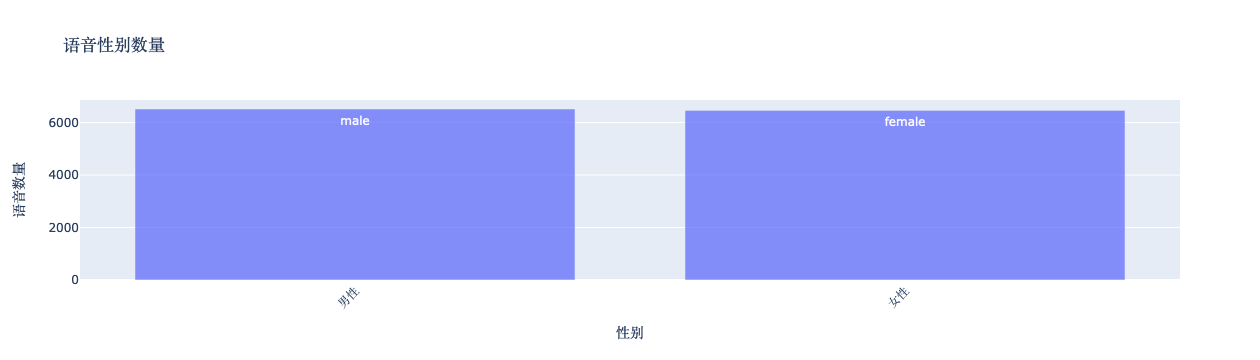

female    6465
male      6516
Name: sex, dtype: int64
一共语音: 12981


In [100]:
# utterance distribution per sex (no need to even out by sex, because data will be separated by gender to train two different models anyway)
trace1 = go.Bar(x=['男性','女性'],
                y=singles["sex"].value_counts(sort=False), 
                text = singles["sex"].unique(),opacity=0.75, textposition='auto')
data = [trace1]
layout = dict(title = '语音性别数量', width=300, height=300,
              xaxis= dict(title='性别',ticklen= 5,zeroline= False, tickmode = 'linear',tickangle=-45),
              yaxis = dict(title='语音数量')
             )
fig = dict(data = data, layout = layout)
iplot(fig)
print(singles["sex"].value_counts().sort_index())
print(f"一共语音: {singles.shape[0]}")

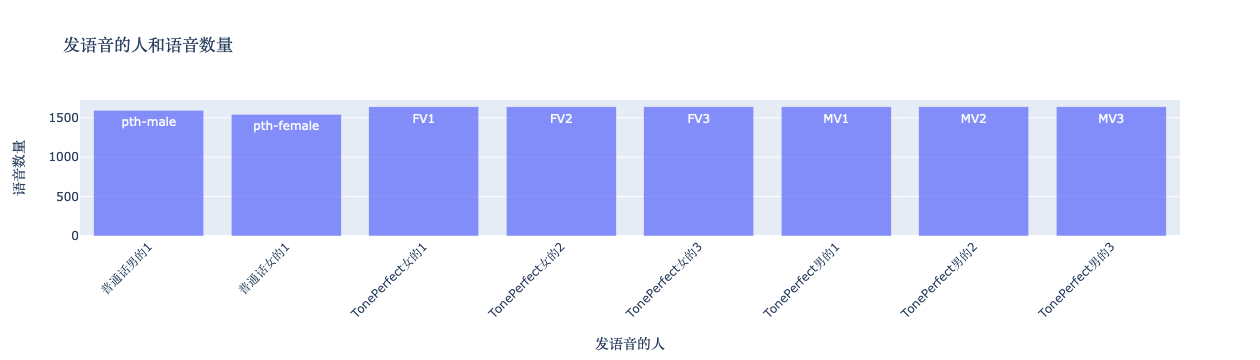

FV1           1640
FV2           1640
FV3           1640
MV1           1640
MV2           1640
MV3           1640
pth-female    1545
pth-male      1596
Name: speaker, dtype: int64
不同的人: 8
男的: 4
女的: 4


In [98]:
# utterance distribution per speaker
#plotly version


trace1 = go.Bar(x=['普通话男的1','普通话女的1','TonePerfect女的1','TonePerfect女的2','TonePerfect女的3','TonePerfect男的1','TonePerfect男的2','TonePerfect男的3'],
                y=singles["speaker"].value_counts(sort=False), 
                text = singles["speaker"].unique(),opacity=0.75, textposition='auto')
data = [trace1]
layout = dict(title = '发语音的人和语音数量', width=600, height=350,
              xaxis= dict(title='发语音的人', ticklen= 5,zeroline= False, tickmode = 'linear',tickangle=-45),
              yaxis = dict(title='语音数量')
             )
fig = dict(data = data, layout = layout)
iplot(fig)

print(singles["speaker"].value_counts().sort_index())
print(f"不同的人: {len(pd.unique(singles['speaker']))}")
print(f"男的: {len(pd.unique(singles.loc[lambda x: singles['sex']=='male', :]['speaker']))}")
print(f"女的: {len(pd.unique(singles.loc[lambda x: singles['sex']=='female', :]['speaker']))}")

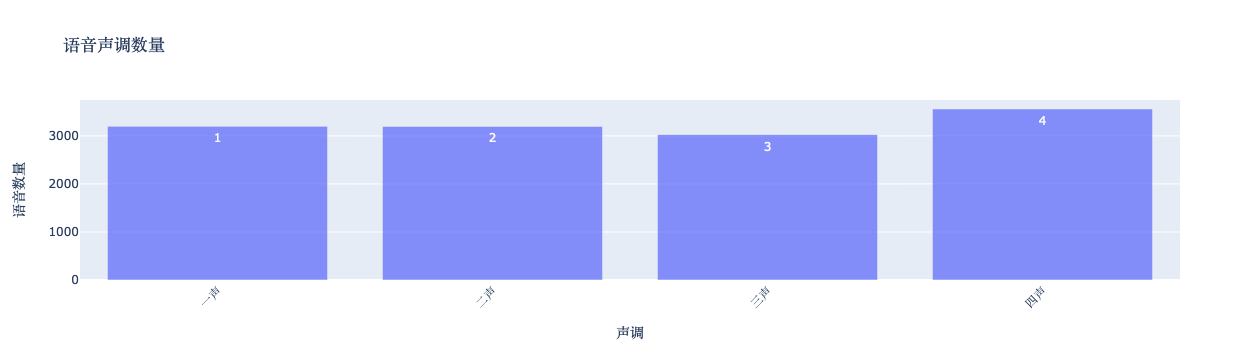

1    3201
2    3196
3    3024
4    3560
Name: tones_orig, dtype: int64
一共语音: 12981


In [101]:
# utterance distribution per tone
#plotly version


trace1 = go.Bar(x=['一声','二声','三声','四声'],
                y=singles["tones_orig"].value_counts(sort=False), 
                text = singles["tones_orig"].unique(),opacity=0.75, textposition='auto')
data = [trace1]
layout = dict(title = '语音声调数量', width=400, height=300,
              xaxis= dict(title='声调',ticklen= 5,zeroline= False, tickmode = 'linear',tickangle=-45),
              yaxis = dict(title='语音数量')
             )
fig = dict(data = data, layout = layout)
iplot(fig)

print(singles["tones_orig"].value_counts().sort_index())
print(f"一共语音: {singles.shape[0]}")

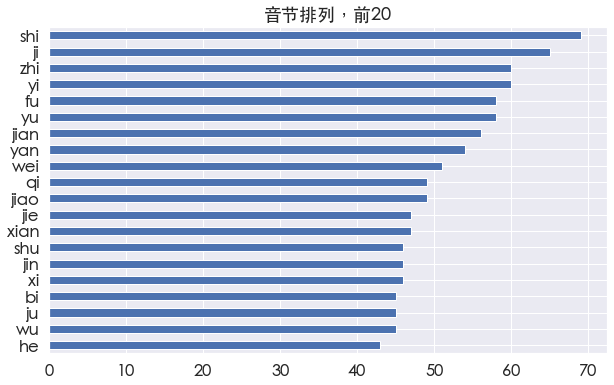

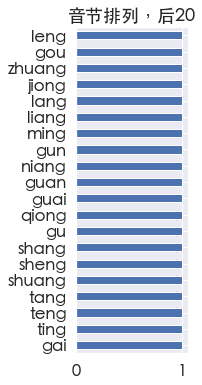

different syllables: 488


In [105]:
# top syllables
df = singles['pinyin2'].value_counts()
df[:20].sort_values(ascending=True).plot(kind='barh',figsize=(10,6), title="音节排列，前20")
plt.show()
plt.close()
df[-20:].sort_values(ascending=True).plot(kind='barh',figsize=(2,6), title="音节排列，后20")
plt.show()
plt.close()
print(f'different syllables: {len(df)}')

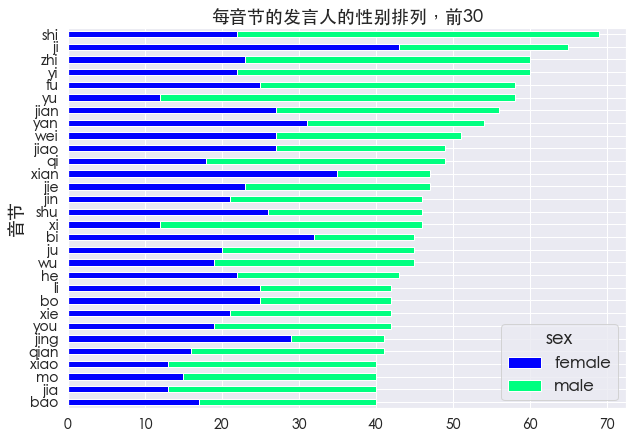

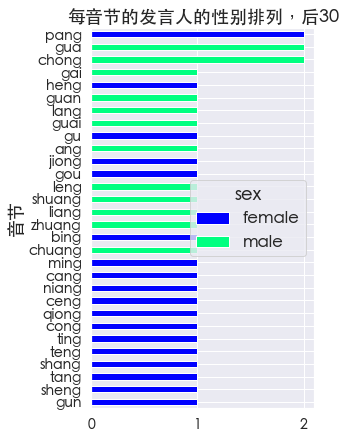

In [346]:
# syllable distribution by gender, top 30
df = singles
# df = (df.groupby("sex")["pinyin2"].apply(lambda x: x.value_counts().head(5)).reset_index(name="counts"))
# df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True).loc[lambda y: y>20]
df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True)
df2 = df.unstack()
# df2.plot(kind="barh", stacked=True, figsize=(10,10), colormap="winter")
df3 = df2.replace(np.nan, '0', regex=True)
df3["female"] = df3["female"].astype(int)
df3["male"] = df3["male"].astype(int)
df3["totals"] = df3["female"]+df3["male"]
df3 = df3.sort_values(by="totals", ascending=True)
df3 = df3.drop("totals", axis=1)

df3[-30:].plot(kind="barh",  title="每音节的发言人的性别排列，前30",
               stacked=True, figsize=(10,7), fontsize=14, colormap="winter", xlabel="音节")
plt.show()
plt.close()

df3[:30].plot(kind="barh",  title="每音节的发言人的性别排列，后30", 
               stacked=True, figsize=(4,7), fontsize=14, colormap="winter", xlabel="音节")
plt.show()
plt.close()

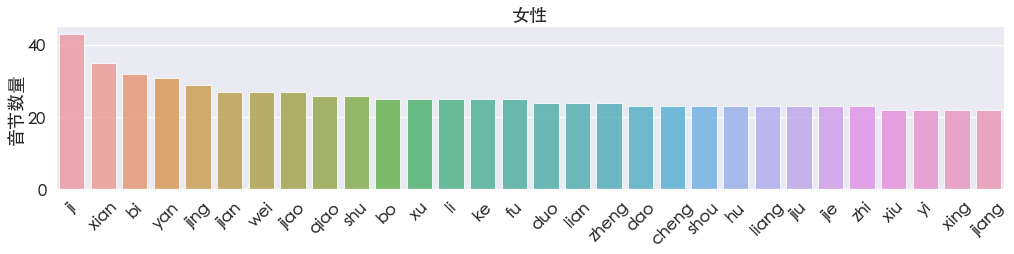

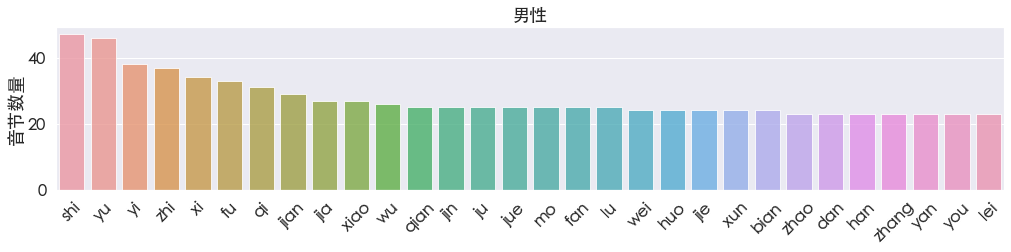

In [363]:
# top syllables by gender
top_entries_count = 30
df = singles.loc[(singles['sex'] == 'female'), :]
yinjie = df["pinyin2"].value_counts()[:top_entries_count,]
plt.figure(figsize=(17,3))
ax = sns.barplot(x=yinjie.index, y=yinjie.values, alpha=0.8)
ax.set_xticklabels (labels = yinjie.index, rotation=45)
ax.set_ylabel("音节数量")
plt.title("女性")
plt.show()
plt.close()
df = singles.loc[(singles['sex'] == 'male'), :]
yinjie = df["pinyin2"].value_counts()[:top_entries_count,]
plt.figure(figsize=(17,3))
ax = sns.barplot(x=yinjie.index, y=yinjie.values, alpha=0.8)
ax.set_xticklabels (labels = yinjie.index, rotation=45)
ax.set_ylabel("音节数量")
plt.title("男性")
plt.show()
plt.close()


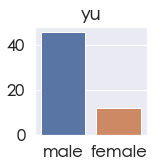

male      46
female    12
Name: sex, dtype: int64


In [199]:
#check gender distribution for a given syllable
syllable = 'yu'
df = singles.loc[(singles['pinyin2'] == syllable), :]
yinjie = df["sex"].value_counts()
plt.figure(figsize=(2,2))
sns.barplot(x = yinjie.index, y = yinjie.values)
plt.title(syllable)
plt.show()
plt.close()
print(yinjie)

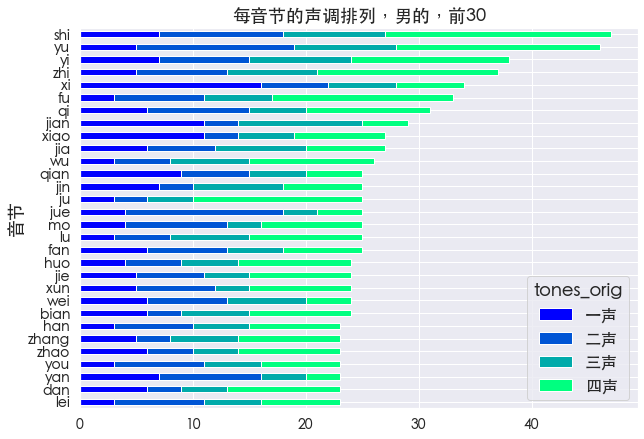

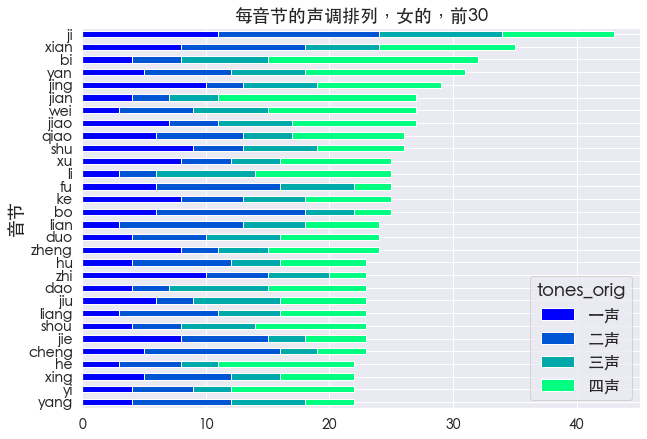

In [212]:
# syllable distribution by tone top 30,  MALE, FEMALE

#MALE
df = singles.copy()
# df = (df.groupby("sex")["pinyin2"].apply(lambda x: x.value_counts().head(5)).reset_index(name="counts"))
# df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True).loc[lambda y: y>20]
df = df.loc[(df['sex'] == "male"), :].groupby(["pinyin2"])["tones_orig"].value_counts().sort_values(ascending=True)
df2 = df.unstack()
# df2.plot(kind="barh", stacked=True, figsize=(10,10), colormap="winter")
df3 = df2.replace(np.nan, '0', regex=True)
df3[1] = df3[1].astype(int)
df3[2] = df3[2].astype(int)
df3[3] = df3[3].astype(int)
df3[4] = df3[4].astype(int)
df3["totals"] = df3[1]+df3[2]+df3[3]+df3[4]
df3 = df3.sort_values(by="totals", ascending=True)
df3 = df3.drop("totals", axis=1)
df3 = df3.rename(columns={1:'一声',2:'二声',3:'三声',4:'四声'})

df3[-30:].plot(kind="barh", title="每音节的声调排列，男的，前30", stacked=True, figsize=(10,7), 
               fontsize=14, colormap="winter", xlabel="音节")
plt.show()
plt.close()

# df3[:30].plot(kind="barh", title="每音节的声调排列，男的，后30", stacked=True, figsize=(5,7), 
#                fontsize=14, colormap="winter", xlabel="音节")
# plt.show()
# plt.close()



#FEMALE
df = singles.copy()
# df = (df.groupby("sex")["pinyin2"].apply(lambda x: x.value_counts().head(5)).reset_index(name="counts"))
# df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True).loc[lambda y: y>20]
df = df.loc[(df['sex'] == "female"), :].groupby(["pinyin2"])["tones_orig"].value_counts().sort_values(ascending=True)
df2 = df.unstack()
# df2.plot(kind="barh", stacked=True, figsize=(10,10), colormap="winter")
df3 = df2.replace(np.nan, '0', regex=True)
df3[1] = df3[1].astype(int)
df3[2] = df3[2].astype(int)
df3[3] = df3[3].astype(int)
df3[4] = df3[4].astype(int)
df3["totals"] = df3[1]+df3[2]+df3[3]+df3[4]
df3 = df3.sort_values(by="totals", ascending=True)
df3 = df3.drop("totals", axis=1)
df3 = df3.rename(columns={1:'一声',2:'二声',3:'三声',4:'四声'})

df3[-30:].plot(kind="barh", title="每音节的声调排列，女的，前30", stacked=True, figsize=(10,7), 
               fontsize=14, colormap="winter", xlabel="音节")
plt.show()
plt.close()

# df3[:30].plot(kind="barh", title="每音节的声调排列，女的，后30", stacked=True, figsize=(5,7), 
#                fontsize=14, colormap="winter", xlabel="音节")
# plt.show()
# plt.close()

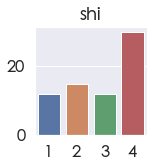

4    30
2    15
1    12
3    12
Name: tones_orig, dtype: int64


In [213]:
#check tone distribution for a given syllable
syllable = 'shi'
df = singles.loc[(singles['pinyin2'] == syllable), :]
yinjie = df["tones_orig"].value_counts()
plt.figure(figsize=(2,2))
sns.barplot(x = yinjie.index, y = yinjie.values)
plt.title(syllable)
plt.show()
plt.close()
print(yinjie)

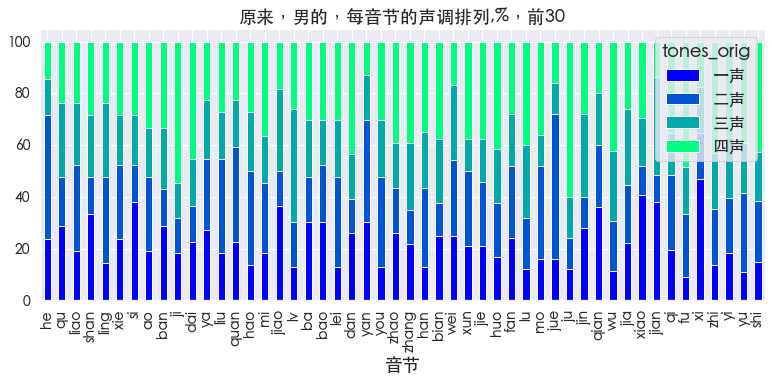

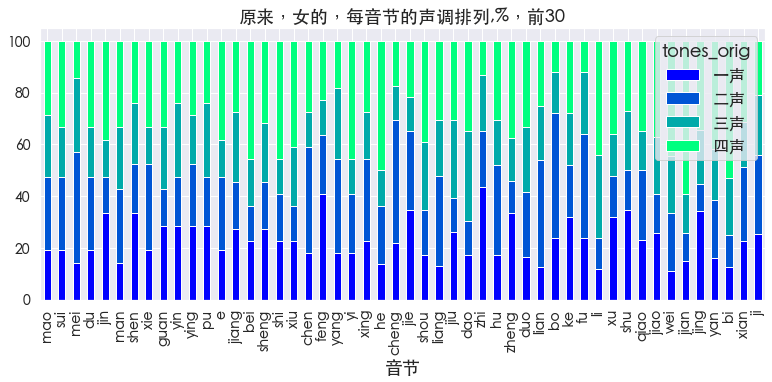

In [18]:
# even out each syllable by tone, separately for each gender
# working on a full dataset

#check distribution BEFORE evening out, MALE
df = singles.copy()
# df = (df.groupby("sex")["pinyin2"].apply(lambda x: x.value_counts().head(5)).reset_index(name="counts"))
# df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True).loc[lambda y: y>20]
df = df.loc[(df['sex'] == "male"), :].groupby(["pinyin2"])["tones_orig"].value_counts().sort_values(ascending=True)
df2 = df.unstack()
# df2.plot(kind="barh", stacked=True, figsize=(10,10), colormap="winter")
df3 = df2.replace(np.nan, '0', regex=True)
df3[1] = df3[1].astype(int)
df3[2] = df3[2].astype(int)
df3[3] = df3[3].astype(int)
df3[4] = df3[4].astype(int)
df3["totals"] = df3[1]+df3[2]+df3[3]+df3[4]
df3 = df3.sort_values(by="totals", ascending=True)
df3[1] = df3[1]/df3["totals"]*100
df3[2] = df3[2]/df3["totals"]*100
df3[3] = df3[3]/df3["totals"]*100
df3[4] = df3[4]/df3["totals"]*100

df3 = df3.drop("totals", axis=1)
df3 = df3.rename(columns={1:'一声',2:'二声',3:'三声',4:'四声'})

df3[-50:].plot(kind="bar", title="原来，男的，每音节的声调排列,%，前30", stacked=True, figsize=(13,5), 
               fontsize=14, colormap="winter", xlabel="音节")
plt.show()
plt.close()




#check distribution BEFORE evening out, FEMALE
df = singles.copy()
# df = (df.groupby("sex")["pinyin2"].apply(lambda x: x.value_counts().head(5)).reset_index(name="counts"))
# df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True).loc[lambda y: y>20]
df = df.loc[(df['sex'] == "female"), :].groupby(["pinyin2"])["tones_orig"].value_counts().sort_values(ascending=True)
df2 = df.unstack()
# df2.plot(kind="barh", stacked=True, figsize=(10,10), colormap="winter")
df3 = df2.replace(np.nan, '0', regex=True)
df3[1] = df3[1].astype(int)
df3[2] = df3[2].astype(int)
df3[3] = df3[3].astype(int)
df3[4] = df3[4].astype(int)
df3["totals"] = df3[1]+df3[2]+df3[3]+df3[4]
df3 = df3.sort_values(by="totals", ascending=True)
df3[1] = df3[1]/df3["totals"]*100
df3[2] = df3[2]/df3["totals"]*100
df3[3] = df3[3]/df3["totals"]*100
df3[4] = df3[4]/df3["totals"]*100

df3 = df3.drop("totals", axis=1)
df3 = df3.rename(columns={1:'一声',2:'二声',3:'三声',4:'四声'})

df3[-50:].plot(kind="bar", title="原来，女的，每音节的声调排列,%，前30", stacked=True, figsize=(13,5), 
               fontsize=14, colormap="winter", xlabel="音节")
plt.show()
plt.close()


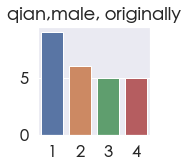

1    9
2    6
3    5
4    5
Name: tones_orig, dtype: int64


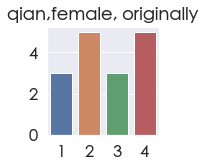

2    5
4    5
1    3
3    3
Name: tones_orig, dtype: int64


In [221]:
#check tone distribution for a given syllable, MALE
syllable = 'qian'
df = singles.loc[(singles['pinyin2'] == syllable)&(singles['sex'] == "male"), :]
yinjie = df["tones_orig"].value_counts()
plt.figure(figsize=(2,2))
sns.barplot(x = yinjie.index, y = yinjie.values)
plt.title(syllable+",male, originally")
plt.show()
plt.close()
print(yinjie)


#check tone distribution for a given syllable, FEMALE
syllable = 'qian'
df = singles.loc[(singles['pinyin2'] == syllable)&(singles['sex'] == "female"), :]
yinjie = df["tones_orig"].value_counts()
plt.figure(figsize=(2,2))
sns.barplot(x = yinjie.index, y = yinjie.values)
plt.title(syllable+",female, originally")
plt.show()
plt.close()
print(yinjie)

In [224]:
# even out each syllable by tone, FOR EACH GENDER

#male
even_data = singles.copy()
even_data.info()
all_syllables = even_data["pinyin2"].value_counts().index
syl_count = {}#minimal syllable count PER TONE
syl_count_current = {}
syl_count_tone = {}

for index, item in enumerate(all_syllables):#iterate through all unique syllables   
    minimal_count = np.min(even_data.loc[(singles['pinyin2'] == item)&(singles['sex'] == "male"), :]["tones_orig"].value_counts())
    syl_count.update({item: minimal_count})#make a dict
    syl_count_current.update({item: 0})
syl_count_tone[1] = syl_count_current.copy()
syl_count_tone[2] = syl_count_current.copy()
syl_count_tone[3] = syl_count_current.copy()
syl_count_tone[4] = syl_count_current.copy()

with tqdm(total=len(singles)) as bar:
    for index, row in singles.iterrows():
        if singles['sex'][index] == "male":
            if syl_count_tone[singles["tones_orig"][index]][singles["pinyin2"][index]] < syl_count[row["pinyin2"]]:
                syl_count_tone[singles["tones_orig"][index]][singles["pinyin2"][index]]= syl_count_tone[singles["tones_orig"][index]][singles["pinyin2"][index]]+1
            else:
                even_data = even_data.drop(index)
        bar.update(1)
# print(syl_count)
even_data = even_data.reset_index(drop=True)
even_data.info()


singles = even_data.copy()


print("*"*50)
#female
# even_data = singles.copy()
# even_data.info()
all_syllables = even_data["pinyin2"].value_counts().index
syl_count = {}#minimal syllable count PER TONE
syl_count_current = {}
syl_count_tone = {}

for index, item in enumerate(all_syllables):#iterate through all unique syllables   
    minimal_count = np.min(even_data.loc[(singles['pinyin2'] == item)&(singles['sex'] == "female"), :]["tones_orig"].value_counts())
    syl_count.update({item: minimal_count})#make a dict
    syl_count_current.update({item: 0})
syl_count_tone[1] = syl_count_current.copy()
syl_count_tone[2] = syl_count_current.copy()
syl_count_tone[3] = syl_count_current.copy()
syl_count_tone[4] = syl_count_current.copy()

with tqdm(total=len(singles)) as bar:
    for index, row in singles.iterrows():
        if singles['sex'][index] == "female":
            if syl_count_tone[singles["tones_orig"][index]][singles["pinyin2"][index]] < syl_count[row["pinyin2"]]:
                syl_count_tone[singles["tones_orig"][index]][singles["pinyin2"][index]]= syl_count_tone[singles["tones_orig"][index]][singles["pinyin2"][index]]+1
            else:
                even_data = even_data.drop(index)
        bar.update(1)
# print(syl_count)
even_data = even_data.reset_index(drop=True)
even_data.info()


filename = "singles_all_fullpath_even(byTone,each_gender).csv"
even_data.to_csv(filename, index=False)
print(f"evened out, saved to: {filename} ")


print("reload original data")
dataset_filename = "singles_all_fullpath.csv"
singles = pd.read_csv(dataset_filename, keep_default_na=False) #to avoid recognizing "nan" as NULL



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12981 entries, 0 to 12980
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         12981 non-null  object
 1   tones_orig  12981 non-null  int64 
 2   pinyin      12981 non-null  object
 3   speaker     12981 non-null  object
 4   subdir      12981 non-null  object
 5   filename    12981 non-null  object
 6   pinyin2     12981 non-null  object
dtypes: int64(1), object(6)
memory usage: 710.0+ KB


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12981/12981 [00:10<00:00, 1274.20it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11701 entries, 0 to 11700
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         11701 non-null  object
 1   tones_orig  11701 non-null  int64 
 2   pinyin      11701 non-null  object
 3   speaker     11701 non-null  object
 4   subdir      11701 non-null  object
 5   filename    11701 non-null  object
 6   pinyin2     11701 non-null  object
dtypes: int64(1), object(6)
memory usage: 640.0+ KB
**************************************************


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11701/11701 [00:09<00:00, 1253.37it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10454 entries, 0 to 10453
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         10454 non-null  object
 1   tones_orig  10454 non-null  int64 
 2   pinyin      10454 non-null  object
 3   speaker     10454 non-null  object
 4   subdir      10454 non-null  object
 5   filename    10454 non-null  object
 6   pinyin2     10454 non-null  object
dtypes: int64(1), object(6)
memory usage: 571.8+ KB
evened out, saved to: singles_all_fullpath_even(byTone,each_gender).csv 
reload original data


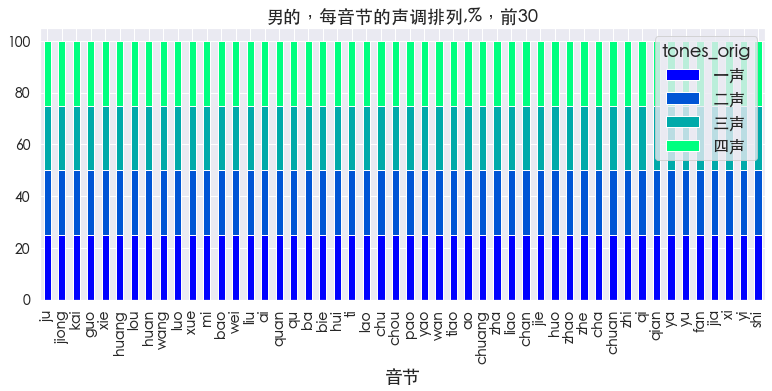

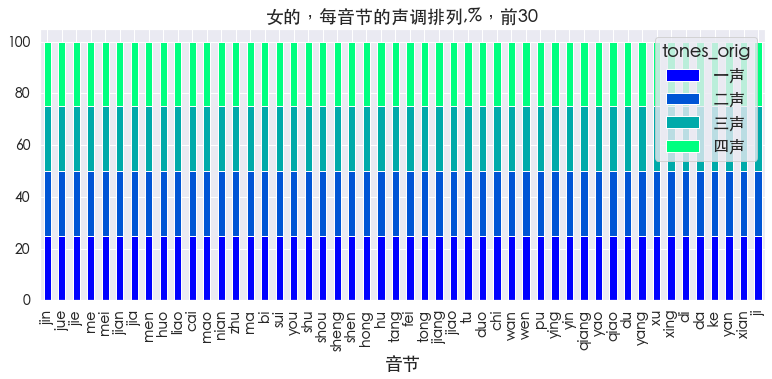

In [108]:
#check distribution AFTER evening out, male

df = even_data.copy()
# df = (df.groupby("sex")["pinyin2"].apply(lambda x: x.value_counts().head(5)).reset_index(name="counts"))
# df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True).loc[lambda y: y>20]
df = df.loc[(df['sex'] == "male"), :].groupby(["pinyin2"])["tones_orig"].value_counts().sort_values(ascending=True)
df2 = df.unstack()
# df2.plot(kind="barh", stacked=True, figsize=(10,10), colormap="winter")
df3 = df2.replace(np.nan, '0', regex=True)
df3[1] = df3[1].astype(int)
df3[2] = df3[2].astype(int)
df3[3] = df3[3].astype(int)
df3[4] = df3[4].astype(int)
df3["totals"] = df3[1]+df3[2]+df3[3]+df3[4]
df3 = df3.sort_values(by="totals", ascending=True)
df3[1] = df3[1]/df3["totals"]*100
df3[2] = df3[2]/df3["totals"]*100
df3[3] = df3[3]/df3["totals"]*100
df3[4] = df3[4]/df3["totals"]*100

df3 = df3.drop("totals", axis=1)
df3 = df3.rename(columns={1:'一声',2:'二声',3:'三声',4:'四声'})

df3[-50:].plot(kind="bar", title="男的，每音节的声调排列,%，前30", stacked=True, figsize=(13,5), 
               fontsize=14, colormap="winter", xlabel="音节")
plt.show()
plt.close()




#check distribution AFTER evening out, FEMALE
df = even_data.copy()
# df = (df.groupby("sex")["pinyin2"].apply(lambda x: x.value_counts().head(5)).reset_index(name="counts"))
# df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True).loc[lambda y: y>20]
df = df.loc[(df['sex'] == "female"), :].groupby(["pinyin2"])["tones_orig"].value_counts().sort_values(ascending=True)
df2 = df.unstack()
# df2.plot(kind="barh", stacked=True, figsize=(10,10), colormap="winter")
df3 = df2.replace(np.nan, '0', regex=True)
df3[1] = df3[1].astype(int)
df3[2] = df3[2].astype(int)
df3[3] = df3[3].astype(int)
df3[4] = df3[4].astype(int)
df3["totals"] = df3[1]+df3[2]+df3[3]+df3[4]
df3 = df3.sort_values(by="totals", ascending=True)
df3[1] = df3[1]/df3["totals"]*100
df3[2] = df3[2]/df3["totals"]*100
df3[3] = df3[3]/df3["totals"]*100
df3[4] = df3[4]/df3["totals"]*100

df3 = df3.drop("totals", axis=1)
df3 = df3.rename(columns={1:'一声',2:'二声',3:'三声',4:'四声'})

df3[-50:].plot(kind="bar", title="女的，每音节的声调排列,%，前30", stacked=True, figsize=(13,5), 
               fontsize=14, colormap="winter", xlabel="音节")
plt.show()
plt.close()


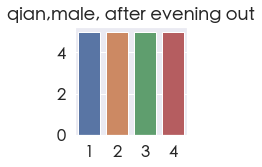

1    5
2    5
3    5
4    5
Name: tones_orig, dtype: int64


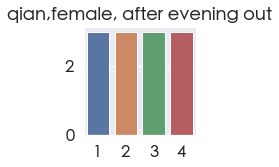

2    3
4    3
1    3
3    3
Name: tones_orig, dtype: int64


In [226]:
#check tone distribution for a given syllable, MALE
syllable = 'qian'
df = even_data.loc[(even_data['pinyin2'] == syllable)&(even_data['sex'] == "male"), :]
yinjie = df["tones_orig"].value_counts()
plt.figure(figsize=(2,2))
sns.barplot(x = yinjie.index, y = yinjie.values)
plt.title(syllable+",male, after evening out")
plt.show()
plt.close()
print(yinjie)


#check tone distribution for a given syllable, FEMALE
syllable = 'qian'
df = even_data.loc[(even_data['pinyin2'] == syllable)&(even_data['sex'] == "female"), :]
yinjie = df["tones_orig"].value_counts()
plt.figure(figsize=(2,2))
sns.barplot(x = yinjie.index, y = yinjie.values)
plt.title(syllable+",female, after evening out")
plt.show()
plt.close()
print(yinjie)

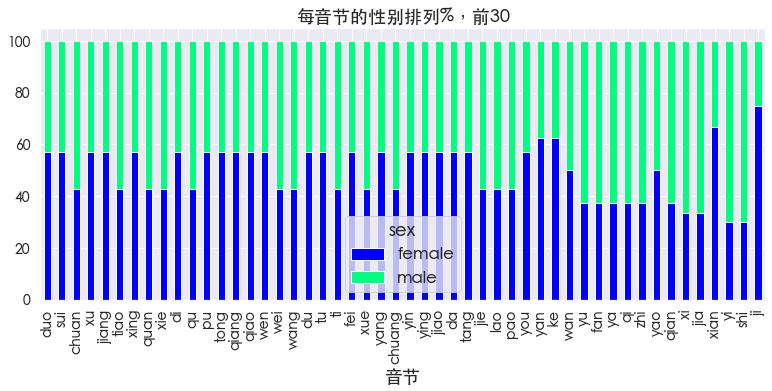

In [227]:
# check syllable/gender balance

df = even_data.copy()
# df = (df.groupby("sex")["pinyin2"].apply(lambda x: x.value_counts().head(5)).reset_index(name="counts"))
# df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True).loc[lambda y: y>20]
df = df.groupby(["pinyin2"])["sex"].value_counts().sort_values(ascending=True)
df2 = df.unstack()
# df2.plot(kind="barh", stacked=True, figsize=(10,10), colormap="winter")
df3 = df2.replace(np.nan, '0', regex=True)
df3["male"] = df3["male"].astype(int)
df3["female"] = df3["female"].astype(int)
# df3[3] = df3[3].astype(int)
# df3[4] = df3[4].astype(int)
df3["totals"] = df3["male"]+df3["female"]
df3 = df3.sort_values(by="totals", ascending=True)
df3["male"] = df3["male"]/df3["totals"]*100
df3["female"] = df3["female"]/df3["totals"]*100
# df3[3] = df3[3]/df3["totals"]*100
# df3[4] = df3[4]/df3["totals"]*100

df3 = df3.drop("totals", axis=1)
# df3 = df3.rename(columns={1:'一声',2:'二声',3:'三声',4:'四声'})

df3[-50:].plot(kind="bar", title="每音节的性别排列%，前30", stacked=True, figsize=(13,5), 
               fontsize=14, colormap="winter", xlabel="音节")
plt.show()
plt.close()


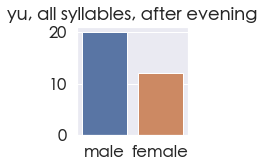

male      20
female    12
Name: sex, dtype: int64


In [10]:
#check gender distribution for a given syllable
syllable = 'yu'
df = even_data.loc[(even_data['pinyin2'] == syllable), :]
yinjie = df["sex"].value_counts()
plt.figure(figsize=(2,2))
sns.barplot(x = yinjie.index, y = yinjie.values)
plt.title(syllable+", all syllables, after evening")
plt.show()
plt.close()
print(yinjie)

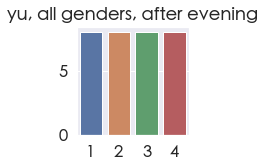

2    8
3    8
4    8
1    8
Name: tones_orig, dtype: int64


In [9]:
#check tone distribution for a given syllable
syllable = 'yu'
df = even_data.loc[(even_data['pinyin2'] == syllable), :]
yinjie = df["tones_orig"].value_counts()
plt.figure(figsize=(2,2))
sns.barplot(x = yinjie.index, y = yinjie.values)
plt.title(syllable+", all genders, after evening")
plt.show()
plt.close()
print(yinjie)

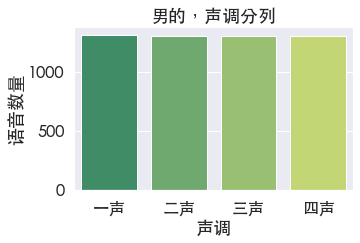

1    1314
2    1306
3    1309
4    1307
Name: tones_orig, dtype: int64
一共语音: 5236
--------------------------------------------------


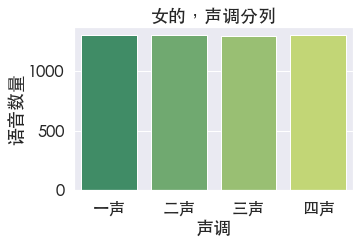

1    1306
2    1307
3    1301
4    1304
Name: tones_orig, dtype: int64
一共语音: 5218


In [8]:
# check tone distribution for each gender after evening out syllables by tone

#CLASS DISTRIBUTION ANALYSIS new
fig = plt.figure(figsize = (5,3))
df = even_data.loc[(even_data['sex'] == "male"), :]
ax = sns.countplot(x=df["tones_orig"],palette = "summer")
ax.set_xticklabels (labels = ('一声','二声','三声','四声'))
plt.title("男的，声调分列")
plt.xlabel('声调')
plt.ylabel('语音数量')
plt.show()
plt.close()
print(df["tones_orig"].value_counts().sort_index())
print(f"一共语音: {df.shape[0]}")

print("-"*50)

fig = plt.figure(figsize = (5,3))
df = even_data.loc[(even_data['sex'] == "female"), :]
ax = sns.countplot(x=df["tones_orig"],palette = "summer")
ax.set_xticklabels (labels = ('一声','二声','三声','四声'))
plt.title("女的，声调分列")
plt.xlabel('声调')
plt.ylabel('语音数量')
plt.show()
plt.close()
print(df["tones_orig"].value_counts().sort_index())
print(f"一共语音: {df.shape[0]}")

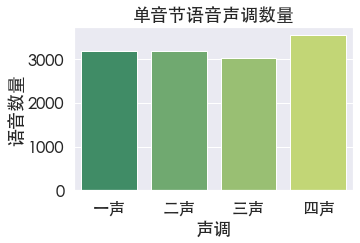

1    3201
2    3196
3    3024
4    3560
Name: tones_orig, dtype: int64
一共语音: 12981


In [174]:
# even out by tone (no need if already even by syllables)

#CLASS DISTRIBUTION ANALYSIS new
fig = plt.figure(figsize = (5,3))
ax = sns.countplot(x=singles["tones_orig"],palette = "summer")
ax.set_xticklabels (labels = ('一声','二声','三声','四声'))
plt.title("单音节语音声调数量")
plt.xlabel('声调')
plt.ylabel('语音数量')
plt.show()
plt.close()
print(singles["tones_orig"].value_counts().sort_index())
print(f"一共语音: {singles.shape[0]}")

In [29]:
# #even out the data by classes (tones)
# it is not necessary to do it

even_data = singles.copy()
one=0
two=0
three=0
four=0
#cut by the most scarce tone
cut_by=min(np.array(even_data["tones_orig"].value_counts()))
if not cut_by == np.max(even_data["tones_orig"].value_counts()):
    for index, row in even_data.iterrows():
        if row['tones_orig']==1:
            if one <cut_by:
                one += 1
            else:
                even_data = even_data.drop(index)
        if row['tones_orig']==2:
            if two <cut_by:
                two += 1
            else:
                even_data = even_data.drop(index)            
        if row['tones_orig']==3:
            if three <cut_by:
                three += 1
            else:
                even_data = even_data.drop(index)            
        if row['tones_orig']==4:
            if four <cut_by:
                four += 1
            else:
                even_data = even_data.drop(index)  
    
    even_data = even_data.reset_index(drop=True) #reset index, because every row is sequental
    filename = "singles_all_fullpath_even(bytone).csv"
    even_data.to_csv(filename, index=False)
    print(f"evened out, saved to: {filename} ")
else:
    print("already even")
print(f"total entries: {even_data.shape[0]}")

evened out, saved to: singles_all_fullpath_even(bytone).csv 
total entries: 12096


# generate features

In [4]:
#generate features

try:
    os.remove(os.path.join("npy.zip"))
    print("npy.zip deleted")
except:
    print("npy.zip not found")
    
fundamental_frequency_or_tone = "tone"

with tqdm(total=dataset_descriptions_all.shape[0]) as bar:
    for index, row in dataset_descriptions_all.iterrows():
        file_path = os.path.join(directory_tones_chinese, row['subdir'], row['filename'])
        y_cut, sr = librosa.core.load(file_path, sr=44100, res_type='kaiser_best')
#         y_cut, sr_ = librosa.effects.trim(y_cut, top_db=10, frame_length=256, hop_length=64)#REMOVE SILENCE
        resulting_image = generate_features(y_cut,sr,fundamental_frequency_or_tone, max_height, max_size) #<--------------------the FUNCTION output
        features_img[index,] = resulting_image
        bar.update(1)
print(f"output is in features_img, shape is: {features_img.shape}")
print("saving...")
path = os.path.join("/Users/Sasha/singles_pth_tp_combined_even(byTone,each_gender)_func_ver10(melspec-db-mfcc128minus0_0_8000Hz)_preprocessed(NOtrim,MeanNorm,preemph).npy")
np.save(path, features_img)
print(f"saved to {path}")
print(the_func_ver)
print(features_img.shape)
print("compressing...")

from os.path import basename
from zipfile import ZipFile, ZIP_DEFLATED
with ZipFile(os.path.join("npy.zip"), 'w', ZIP_DEFLATED) as zipf:
    zipf.write(path, basename(path)) #remove path from the filename in the archive
zipf.close()
try:
    os.remove(os.path.join(path))#delete the .npy
    print(f"{path} deleted")
except:
    print(f"{path} not found")

print("done")


npy.zip not found


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10454/10454 [06:20<00:00, 27.44it/s]


output is in features_img, shape is: (10454, 128, 130, 1)
saving...
saved to /Users/Sasha/singles_pth_tp_combined_even(byTone,each_gender)_func_ver10(melspec-db-mfcc128minus0_0_8000Hz)_preprocessed(NOtrim,MeanNorm,preemph).npy
current function: v10 - tone (128minus0 MFCCs 0_8000Hz, mean norm, pre-emph)
(10454, 128, 130, 1)
compressing...
/Users/Sasha/singles_pth_tp_combined_even(byTone,each_gender)_func_ver10(melspec-db-mfcc128minus0_0_8000Hz)_preprocessed(NOtrim,MeanNorm,preemph).npy deleted
done


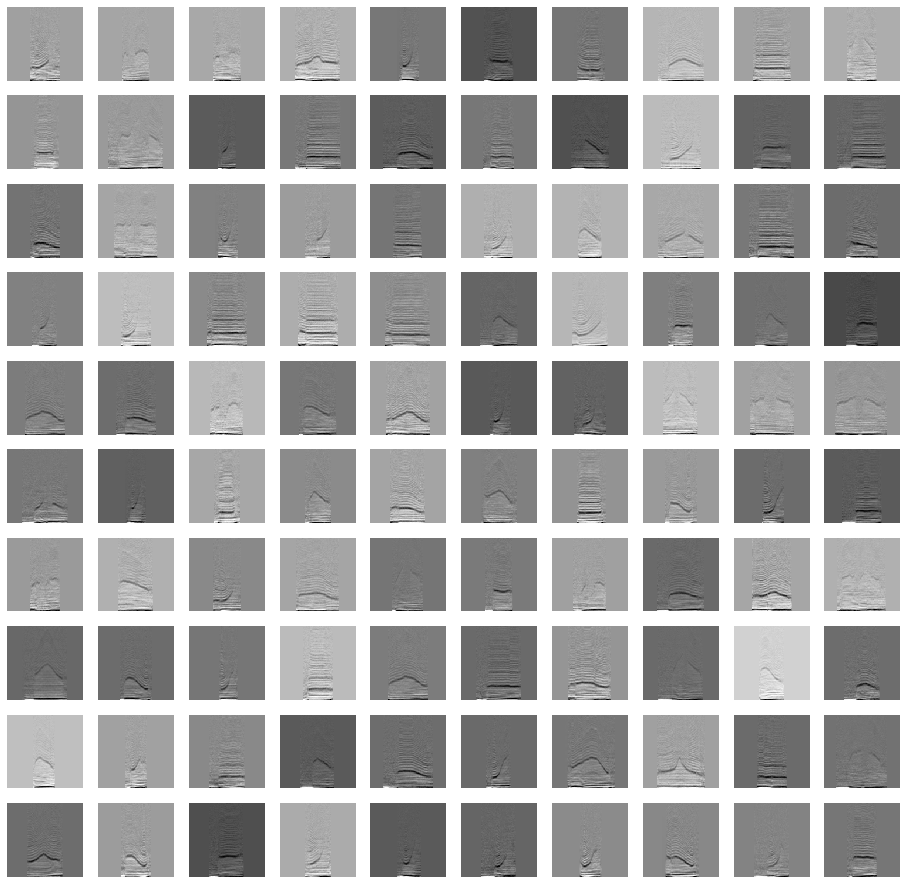

In [69]:
# visualize generated features

fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(16, 16))
# i=0

for row in ax:
    for col in row:
        randomnumber = np.random.randint(features_img.shape[0])
        col.imshow(features_img[randomnumber,:,:,0], origin='lower', aspect='auto', interpolation='nearest')
        col.axis('off')

    #         i+=1

plt.show()
plt.close()



# training

training is done in google colab, so there is a set of imports just for training

In [ ]:
#for colab
%%capture
!pip install tensorflow==2.4.0
!pip install keras==2.4.3
!pip install wandb
!pip install keract
!pip install scikit-learn==0.23.2 #for keract

In [1]:
#set variables and import libraries

import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    import os
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    import tensorflow as tf
    from tensorflow.keras.models import Model, Sequential
    from tensorflow.keras.layers import Dense, Flatten, Dropout
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
    from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
    from keract import get_activations, display_activations, display_heatmaps
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    base_path = '/content/drive/MyDrive/tones-pronunciation(code)/'
    from google.colab import drive
    drive.mount('/content/drive')
    # EXPERIMENTS TRACKING
    import wandb
    from wandb.keras import WandbCallback
    wandb.login()
else:
    base_path = ""
    %run tones-pronunciation-only-imports.ipynb

# max_size = 130
# max_height = 128
# tensor_dimensions = 2

# directory_tones_russian = os.path.join(base_path,'/tones_russian') 
# russian_dir = directory_tones_russian
# russian_fname = "000.wav"
directory_tones_chinese = base_path
class_names=("tone 1","tone 2","tone 3","tone 4")
print(directory_tones_chinese)


In [ ]:
# reload and prepare the data

features_filename = "singles_pth_tp_combined_even(byTone,each_gender)_func_ver10(melspec-db-mfcc128minus0_0_8000Hz)_preprocessed(NOtrim,MeanNorm,preemph).npy"

path = os.path.join(features_filename)
X = np.load(path)

dataset_filename = "singles_all_fullpath_even(byTone,each_gender).csv"
dataset_descriptions_all = pd.read_csv(os.path.join(base_path,dataset_filename), keep_default_na=False) #to avoid recognizing "nan" as NULL
y = np.array(dataset_descriptions_all["tones_orig"])


if True:#True=separate into male/female datasets or not
    #separate male and female data
    X_f = []
    X_m = []
    y_f = []
    y_m = []
    if len(X) == len(dataset_descriptions_all):
        with tqdm(total=len(X)) as bar:
            for index in range(len(X)):
                if dataset_descriptions_all["sex"][index] == "male":
                    X_m.append(X[index])
                    y_m.append(y[index])
                else:
                    X_f.append(X[index])
                    y_f.append(y[index])
                bar.update(1)

    print(X.shape, y.shape)

    print (f"male entries: {len(X_m),len(y_m)},\nfemale entries: {len(X_f),len(y_f)}")


    #visualize and check
    print('-'*40)
    randomnumber = np.random.randint(len(X_m))
    print(f"MALE X_m total entries: {len(X_m)}")
    print(f"random entry: {randomnumber}\n")
    print(f"tone {y_m[randomnumber]}:")
    plt.imshow(np.array(X_m)[randomnumber, :,:,0], aspect="auto")#, cmap=plt.cm.flag)
    plt.show()
    plt.close()
    print('-'*40)
    randomnumber = np.random.randint(len(X_f))
    print(f"FEMALE X_f total entries: {len(X_f)}")
    print(f"random entry: {randomnumber}\n")
    print(f"tone {y_f[randomnumber]}:")
    plt.imshow(np.array(X_f)[randomnumber, :,:,0], aspect="auto")#, cmap=plt.cm.flag)
    plt.show()
    plt.close()

    #CHOOSE
    if False: #False = FEMALE, True = MALE
        #load male data into X y
        X = np.array(X_m)
        y = np.array(y_m)
        print("loaded MALE")
        current_data_loaded = "male"
    else:
        #load female data into X y
        X = np.array(X_f)
        y = np.array(y_f)
        print("loaded FEMALE")
        current_data_loaded = "female"

    print(X.shape, y.shape)
    
else:
    print("loaded MALE+FEMALE")
    current_data_loaded = "male+female"
    print('-'*40)
    randomnumber = np.random.randint(len(X))
    print(f"MALE+FEMALE X total entries: {len(X)}")
    print(f"random entry: {randomnumber}\n")
    print(f"tone {y[randomnumber]}:")
    plt.imshow(np.array(X)[randomnumber, :,:,0], origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.flag)
    plt.title('mfcc imshow')
    plt.ylabel('MFCC Coefficient Index')
    plt.xlabel('Frame Index')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    plt.close()    


#prepare for conversion to categorical
print(y)
if y.max()==4:
    print("preparing y for conversion to categorical...")
    for i in range(y.size):
        y[i] = y[i]-1
    print("prepared")
else:
    print("already converted or something is wrong")
print(y)

print(X.shape, y.shape)
!ls

In [ ]:
#Split once to get the test and training set
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42, 
                                                    shuffle=True, stratify=y)
print(X_train.shape,X_test.shape)



#Split twice to get the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, 
                                                  shuffle=True, stratify=y_train)
print(X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val))



#encode labels into categories, one-hot vector
number_of_classes = 4
if y_train.ndim==1:
    print(f"dimensions before: {y_train.ndim}")
    y_train = to_categorical(y_train, num_classes=number_of_classes)
    y_test = to_categorical(y_test, num_classes=number_of_classes)
    y_val = to_categorical(y_val, num_classes=number_of_classes)
    print(f"dimensions converted: {y_train.ndim}")
else:
    print("already converted")

#check
print(X_train[0,].shape, y_train[0,].shape)

input_shape=(X_train[0,].shape)
train_test_val_count = f"{len(y_train)}, {len(y_test)}, {len(y_val)}"



# from sklearn.utils import class_weight
# y_ints = [y.argmax() for y in y_train]
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_ints), y=y_ints)

df = pd.DataFrame(y_train)
df.value_counts()

### VGG based model

In [ ]:

# Initialize "weights and biases" 
# set the hyperparameters
run = wandb.init(project='tones-pronunciation-only',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0005,
                     "epochs": 20,
                     "batch_size": 512,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "singles-pth-tp",
                     "dropout": 0.0,
                     "model_version": 11,
                     "model_data": current_data_loaded,
                     "features": features_filename,
                     "train_test_val_count": train_test_val_count,
                     "pooling": "max"
                 })
config = wandb.config 

cfad = config.as_dict()
for item in cfad:
    print(item, cfad[item])

In [ ]:
# model version 11
#is based on VGG
#https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
#https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
#https://arxiv.org/pdf/1207.0580.pdf
#https://arxiv.org/pdf/1904.03392.pdf
#http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf


def create_CNNmodel(input_shape, number_of_classes):
    # Step 1 - Convolution
    CNNmodel = Sequential()
    CNNmodel.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(Conv2D(32, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    #add layer
    CNNmodel.add(Conv2D(64, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(Conv2D(64, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#     CNNmodel.add(Dropout(config.dropout))
    # Adding second convolutional layer             
    CNNmodel.add(Conv2D(128, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(Conv2D(128, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#     CNNmodel.add(Dropout(config.dropout))
    # Adding third convolutional layer
    CNNmodel.add(Conv2D(256, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(Conv2D(256, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(Conv2D(256, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#     CNNmodel.add(Dropout(config.dropout))
    # Adding fourth convolutional layer
    CNNmodel.add(Conv2D(256, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(Conv2D(256, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(Conv2D(256, (3, 3), padding='same'))
    CNNmodel.add(Activation("relu"))
    CNNmodel.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#     CNNmodel.add(Dropout(config.dropout))
    # Step 3 - Flattening             
    CNNmodel.add(Flatten())
    # Step 4 - Full connection
    CNNmodel.add(Dense(units = 512, activation = 'relu'))
    CNNmodel.add(Dropout(config.dropout))
    CNNmodel.add(Dense(units = 512, activation = 'relu'))
    CNNmodel.add(Dropout(config.dropout))
    CNNmodel.add(Dense(number_of_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
    CNNmodel.compile(optimizer=optimizer,
                     loss=tf.keras.losses.categorical_crossentropy,
                     metrics=['accuracy'])
    return CNNmodel

#for GPU:
with tf.device('/device:GPU:0'):
    CNNmodel = create_CNNmodel (input_shape, number_of_classes)



In [ ]:
CNNmodel.summary()

In [ ]:
# training. the best model is saved to a checkpoint
%%time
tf.keras.backend.clear_session()
import math

checkpoint_filepath = os.path.join(base_path, "saved_models/CNN_checkpoint")

def lr_step_decay(epoch, lr):
    drop_rate = 0.99
    epochs_drop = 1.0
    return config.learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

my_callbacks = [
    ModelCheckpoint(monitor="val_loss", mode='min', filepath=checkpoint_filepath, save_weights_only=False, save_best_only=True, verbose=1),
    WandbCallback(data_type='image', validation_data=(X_val, y_val), labels=class_names, verbose=1, save_model=False),
    LearningRateScheduler(lr_step_decay, verbose=1) #https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
]

history = CNNmodel.fit(X_train, y_train, 
                        epochs=config.epochs, 
                        batch_size=config.batch_size,
                        validation_data = (X_val, y_val),
                        callbacks=my_callbacks,
                      verbose=1,
                       
                       )

run.finish()

In [ ]:
# #save as MALE
# CNNmodel.save("saved_models/CNNmodel_male")

In [ ]:
# #save as FEMALE
# CNNmodel.save("saved_models/CNNmodel_female")

In [ ]:
# #LOAD MALE
CNNmodel_male = tf.keras.models.load_model(os.path.join(base_path, "saved_models/CNNmodel_male"))

In [ ]:
# #LOAD FEMALE
CNNmodel_female = tf.keras.models.load_model(os.path.join(base_path, "saved_models/CNNmodel_female"))

### model performance

In [ ]:
# Generating layer output visualizations
# https://www.machinecurve.com/index.php/2019/12/02/visualize-layer-outputs-of-your-keras-classifier-with-keract/

keract_inputs = X_test[:1]
keract_targets = y_test[:1]
activations = get_activations(CNNmodel_female, keract_inputs)
display_activations(activations, cmap="gray", save=False)

In [ ]:
#Generating layer activation heatmaps
keract_inputs = X_test[:1]
keract_targets = y_test[:1]
activations = get_activations(CNNmodel_female, keract_inputs)
display_heatmaps(activations, keract_inputs, save=False) #needs scikit-learn 0.23.2

In [ ]:
y_pred = CNNmodel.predict(X_test)

In [ ]:
cr = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=class_names)
print(cr)

In [ ]:
y_pred = CNNmodel.predict(X_test)
# cm = metrics.confusion_matrix(y_test, y_pred)
cm = tf.math.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
plt.figure(figsize=(5, 4))
sns.heatmap(cm, xticklabels=('一声','二声','三声','四声'), yticklabels=('一声','二声','三声','四声'), 
            annot=True, fmt='g')
plt.xlabel('预测的')
plt.ylabel('实际的')
plt.title('男性模型')
plt.show()
plt.close()

In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,config.epochs+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()
plt.close()

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.close()

In [ ]:
score = CNNmodel.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = CNNmodel.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

In [ ]:
# get the features and
# generate activation heatmaps for the recording
file_path = os.path.join(russian_dir, russian_fname)
max_size = 130
max_height = 128
tensor_dimensions = 2
fundamental_frequency_or_tone = "tone"
features_img_rus=np.empty((1,max_height,max_size,tensor_dimensions-1))
y_cut, sr = librosa.core.load(file_path, sr=None)    
features_img_rus[0,] = generate_features(y_cut,sr,fundamental_frequency_or_tone)

#Generating layer activation heatmaps
CHOOSE_MODEL = CNNmodel_male #load the model from file
keract_inputs = features_img_rus
activations = get_activations(CHOOSE_MODEL, keract_inputs)
display_heatmaps(activations, keract_inputs, save=False) #needs scikit-learn 0.23.2

# making predictions

/Users/sasha/Desktop/tones-pronunciation(data)/tones_russian_experiment/F1/wav/chunks/04pa2.wav
originally: 37133
after silence trim: 37133
function: current function: v10 - tone (128minus0 MFCCs 0_8000Hz, mean norm, pre-emph)
用了 1.07 秒钟做评价



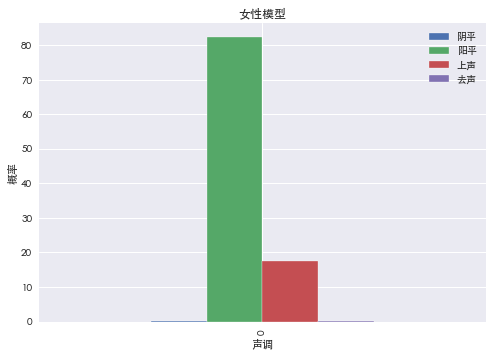

        阴平        阳平        上声       去声
0 0.027651 82.407768 17.559729 0.004853
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


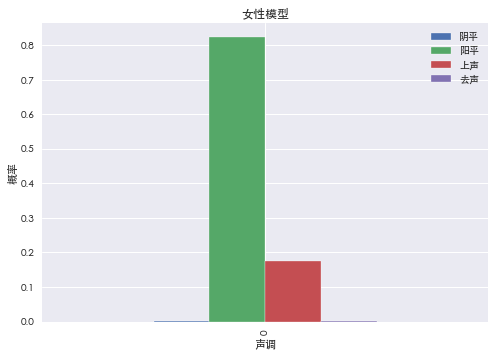

        阴平       阳平       上声       去声
0 0.000277 0.824078 0.175597 0.000049
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
originally: 37133
after silence trim: 37133


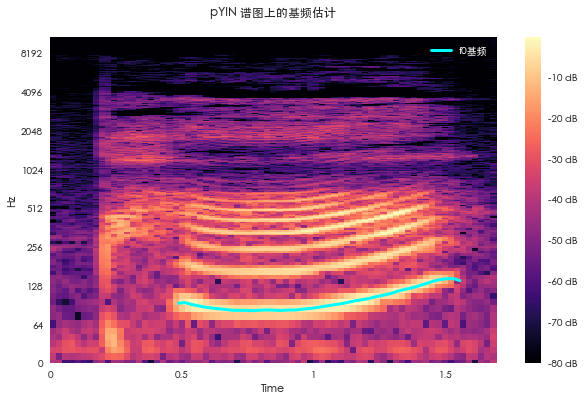

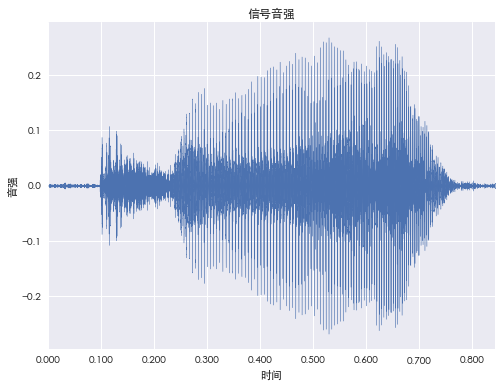

--------------------------------------------------
中位数的基频，: 93 Hz
--------------------------------------------------


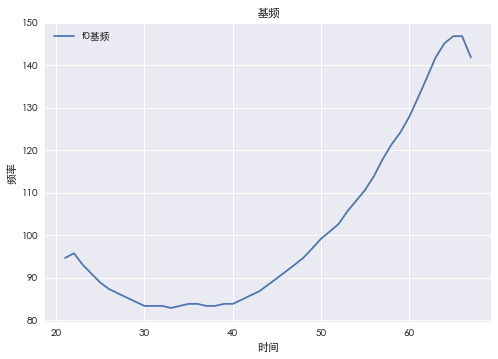

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
originally: 37133
after silence trim: 37133
it took 0.16 sec. to run the function


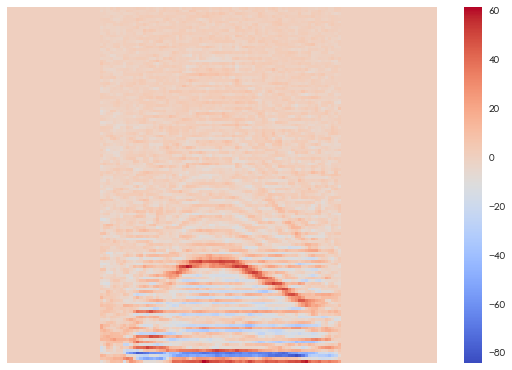

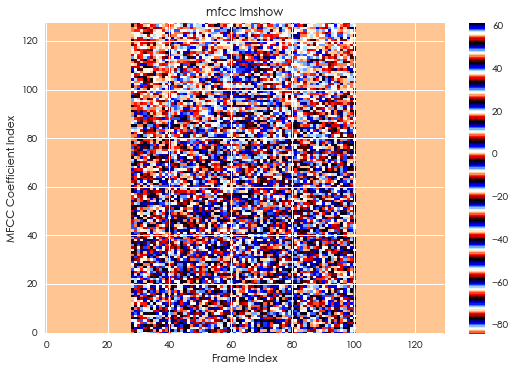

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


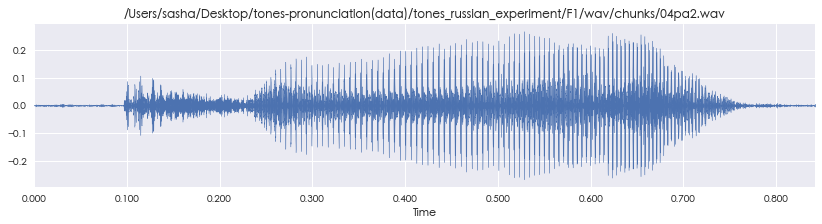

filename:/Users/sasha/Desktop/tones-pronunciation(data)/tones_russian_experiment/F1/wav/chunks/04pa2.wav,
 channels: 1, time:0.842 sec, native sample rate:48000 Hz, size:40416 elements 


In [ ]:
#make prediction and visualization for a certain test recording

YINJIE = "pa2"
directory_tones_russian_wav = os.path.join(project_dataset_folder,'tones_russian_experiment',TEST_SUBJECT,"wav/chunks") 

file_path = os.path.join(directory_tones_russian_wav, testsubjectdata[(testsubjectdata["yinjie"] == str(YINJIE))]["filename"].values[0]+".wav")
print(file_path)
if "F" in TEST_SUBJECT:
    pred(file_path, CNNmodel_female, "女性模型")
    print("x"*50)
    newdata = batch_pred(file_path, CNNmodel_female, "女性模型")
    df = pd.DataFrame(newdata[0], columns=class_names)
    df.plot(kind="bar", ylabel="概率", xlabel="声调", title="女性模型")
    plt.show()
    plt.close()
    print(df)

else:
    pred(file_path, CNNmodel_male, "男性模型")
    print("x"*50)
    newdata = batch_pred(file_path, CNNmodel_male, "男性模型")
    df = pd.DataFrame(newdata[0], columns=class_names)
    df.plot(kind="bar", ylabel="概率", xlabel="声调", title="男性模型")
    plt.show()
    plt.close()
    print(df)


# print(file_path)
print("x"*50)
visualize_f0(file_path)
print("x"*50)
visualize_features(file_path)
print("x"*50)
visualizeandplay(file_path)

In [271]:
# batch predictions

def batch_pred (file_path, model, model_desc):
    global max_height
    global max_size
    global tensor_dimensions
    global the_func_ver
#     max_size = 130
#     max_height = 128
#     tensor_dimensions = 2
    fundamental_frequency_or_tone = "tone"
    start_time=time.time()
    features_img_rus=np.empty((1,max_height,max_size,tensor_dimensions-1))
    y_cut, sr = librosa.core.load(file_path, sr=44100, res_type='kaiser_best')  
#     y_cut, sr_ = librosa.effects.trim(y_cut, top_db=20, frame_length=256, hop_length=64)
    features_img_rus[0,] = generate_features(y_cut,sr,fundamental_frequency_or_tone,max_height,max_size)
    rus_preds_result = model.predict(features_img_rus)

    return rus_preds_result, features_img_rus[0,], y_cut

In [309]:
TEST_SUBJECT = "F4"
MODELGEN = "_baseline4_"
directory_tones_russian_wav = os.path.join(project_dataset_folder,'tones_russian_experiment',TEST_SUBJECT,"wav/chunks") 
print(directory_tones_russian_wav)
csvpath = os.path.join(basepath,TEST_SUBJECT+"_CNNmodel_checkpoint_eval.csv")

/Users/sasha/Desktop/tones-pronunciation(data)/tones_russian_experiment/F4/wav/chunks


In [310]:
#POPULATE A LIST OF FILES
# audio_dir = directory_tones_russian_wav
if os.path.exists(directory_tones_russian_wav):#error handling
    ext = '.wav' # Select your file delimiter
    audio_files = [i for i in os.listdir(directory_tones_russian_wav) if os.path.splitext(i)[1] == ext]# Select only files with the ext extension
    audio_files.sort()

print(directory_tones_russian_wav)
print(audio_files)
print(len(audio_files))

/Users/sasha/Desktop/tones-pronunciation(data)/tones_russian_experiment/F4/wav/chunks
['01ba1.wav', '01ba2.wav', '01ba3.wav', '01ba4.wav', '02bi1.wav', '02bi2.wav', '02bi3.wav', '02bi4.wav', '03bu1.wav', '03bu2.wav', '03bu3.wav', '03bu4.wav', '04pa1.wav', '04pa2.wav', '04pa3.wav', '04pa4.wav', '05pi1.wav', '05pi2.wav', '05pi3.wav', '05pi4.wav', '06pu1.wav', '06pu2.wav', '06pu3.wav', '06pu4.wav', '07ta1.wav', '07ta2.wav', '07ta3.wav', '07ta4.wav', '08ti1.wav', '08ti2.wav', '08ti3.wav', '08ti4.wav', '09tu1.wav', '09tu2.wav', '09tu3.wav', '09tu4.wav', '10da1.wav', '10da2.wav', '10da3.wav', '10da4.wav', '11di1.wav', '11di2.wav', '11di3.wav', '11di4.wav', '12du1.wav', '12du2.wav', '12du3.wav', '12du4.wav', '13yi1.wav', '13yi2.wav', '13yi3.wav', '13yi4.wav', '14wu1.wav', '14wu2.wav', '14wu3.wav', '14wu4.wav']
56


In [ ]:
#make predictions and save to csv
#also save generated features into .npy

testsubjectdata = pd.DataFrame(columns=("test_sub","model","filename","1","2","3","4","len"))

#collect audio data for visualizations
features_img_testsub = np.empty((56,max_height,max_size,tensor_dimensions-1))


with tqdm(total=len(audio_files)) as bar:
    for filename in audio_files:
        file_path = os.path.join(directory_tones_russian_wav, filename)
        if "F" in TEST_SUBJECT:
            newdata = batch_pred(file_path, CNNmodel_female, "female")
            model_name = "CNNmodel_female"
        else:
            newdata = batch_pred(file_path, CNNmodel_male, "male")
            model_name = "CNNmodel_male"
        features_img_testsub[len(testsubjectdata),] = newdata[1]#populate with MFCC data
        audiolen = len(newdata[2])
        newdata = newdata[0][0]
        testsubjectdata = testsubjectdata.append({'test_sub': TEST_SUBJECT, 'model': model_name, 'filename': filename.replace(".wav",""),'1': newdata[0],'2': newdata[1],'3': newdata[2],'4': newdata[3],'len': audiolen}, ignore_index=True)
        bar.update(1)
        
csvpath = os.path.join(basepath,TEST_SUBJECT+MODELGEN+"eval.csv")
testsubjectdata.to_csv(csvpath, index=False)
np.save(basename(csvpath).replace("eval.csv", "features_img.npy"), features_img_testsub)#absolute path is not working here????

print(csvpath)
# print(model_name)
# print(testsubjectdata.info())
print(testsubjectdata.head(5))
print(directory_tones_russian_wav)

### visualize features of test recordings

generated features for M2


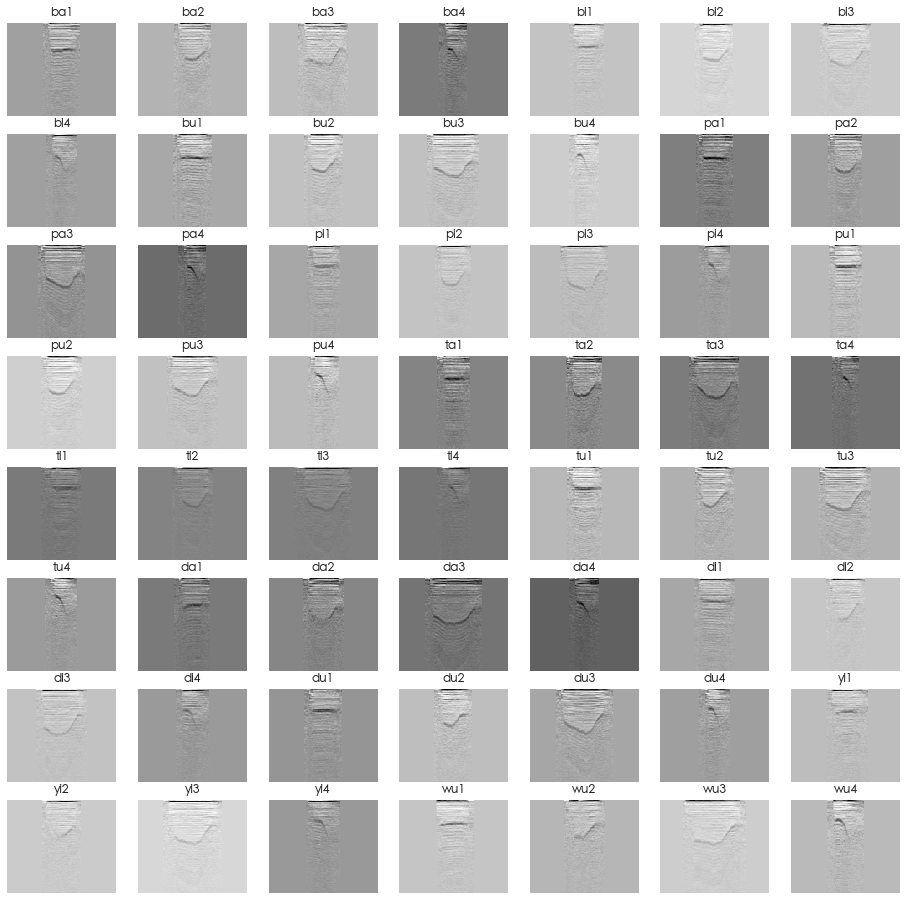

In [318]:
    
fig, ax = plt.subplots(nrows=8, ncols=7, figsize=(16, 16))
fig.set_dpi(100)
i=0
print(f"generated features for {TEST_SUBJECT}")
for row in ax:
    for col in row:
#         col.imshow(features_img_testsub[i,:,:,0], origin='lower', aspect='auto', interpolation='nearest')
        col.imshow(features_img_testsub[i,:,:,0], aspect='auto', interpolation='nearest')
        col.axis('off')
#         col.set_title(np.argmax(np.array(testsubjectdata.iloc[i][{"1","2","3","4"}]),axis=0)+1)
        col.set_title(testsubjectdata.iloc[i]["filename"][2:])
        i+=1

plt.show()
plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [03:25<00:00,  3.68s/it]


pYIN 谱图上的基频估计 for M1


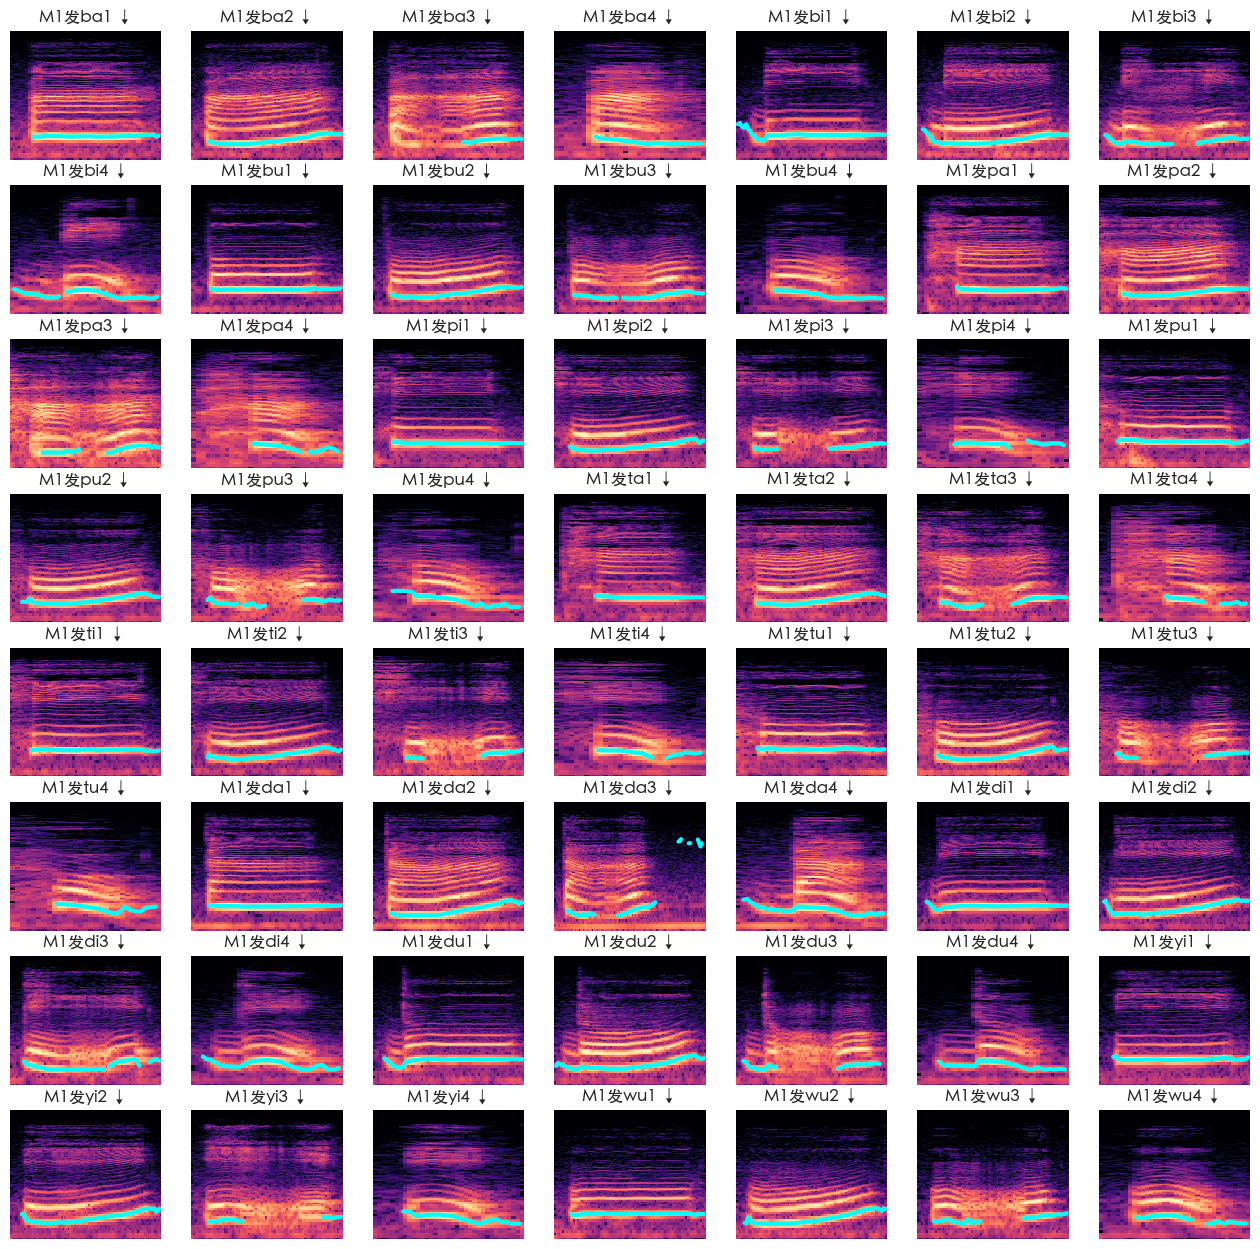

In [365]:
#visualize f0  


fig, ax = plt.subplots(nrows=8, ncols=7, figsize=(16, 16))
fig.set_dpi(100)
i=0
fundamental_frequency_or_tone = "fundamental_frequency"

with tqdm(total=len(testsubjectdata)) as bar:
    for row in ax:
        for col in row:
            file_path = os.path.join(directory_tones_russian_wav,testsubjectdata.iloc[i]["filename"]+".wav")        
            y_cut, sr = librosa.core.load(file_path, sr=44100, res_type='kaiser_best')
            features = generate_features(y_cut,sr,fundamental_frequency_or_tone, max_height, max_size)  #return image, f0, f0_median, f0_padded
    #     f0, voiced_flag, voiced_probs = librosa.pyin(y_cut, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
            if features[2] != None: #plot the graph only if median f0 can be calculated
                times = librosa.times_like(features[1])
                D = librosa.amplitude_to_db(np.abs(librosa.stft(y_cut)), ref=np.max)
                img = librosa.display.specshow(D, x_axis='time', y_axis='log',ax=col)
                col.plot(times, features[1], color='cyan', linewidth=3)
                col.axis('off')
                col.set_title(f'{TEST_SUBJECT}发{testsubjectdata.iloc[i]["filename"][2:]} ↓')
            i+=1
            bar.update(1)
#             break
#         break
print(f"pYIN 谱图上的基频估计 for {TEST_SUBJECT}")
plt.show()
plt.close()


In [23]:
# convert the data to percentage
#RUN ONLY ONCE!
pd.set_option('display.float_format', '{:.6f}'.format)
# print(testsubjectdata.drop(["model","test_sub"],axis=1).to_string(index=False))
testsubjectdata["1"] = testsubjectdata["1"]*100
testsubjectdata["2"] = testsubjectdata["2"]*100
testsubjectdata["3"] = testsubjectdata["3"]*100
testsubjectdata["4"] = testsubjectdata["4"]*100
testsubjectdata["tone"] = testsubjectdata.apply(lambda x: x["filename"][-1], axis=1)
testsubjectdata["accuracy"] = testsubjectdata.apply(lambda x: x[x["tone"]], axis=1)
testsubjectdata["yinjie"] = testsubjectdata.apply(lambda x: x["filename"][2:], axis=1)
testsubjectdata["len"] = testsubjectdata["len"]/44100*100

print(f'total length of all the recordings of {TEST_SUBJECT} test subject is {testsubjectdata["len"].sum()}')
testsubjectdata.head(5)

total length of all the recordings of F4 test subject is 3183.40589569161


,test_sub,model,filename,1,2,3,4,len,tone,accuracy,yinjie
0,F4,CNNmodel_female,01ba1,90.404564,3.027489,0.019106,6.548836,50.199546,1,90.404564,ba1
1,F4,CNNmodel_female,01ba2,14.583947,79.645930,2.027513,3.742614,49.498866,2,79.645930,ba2
2,F4,CNNmodel_female,01ba3,0.418116,99.009925,0.086248,0.485714,62.800454,3,0.086248,ba3
3,F4,CNNmodel_female,01ba4,0.934959,0.042107,0.000441,99.022490,34.399093,4,99.022490,ba4
4,F4,CNNmodel_female,02bi1,96.841264,0.967942,0.019241,2.171552,50.199546,1,96.841264,bi1


In [ ]:
#print data for copy to the disertation
df = pd.DataFrame(testsubjectdata, columns=["yinjie","1","2","3","4"],)
# print(df.to_string(index=False))
df #then copy and paste plain text

In [ ]:
# plot accuracy of all tones

# plt.style.use("seaborn")
plt.rcParams['font.family'] = ['Heiti TC']

df = testsubjectdata.copy()

print(csvpath)

df = df.copy()

df = df.rename(columns={"accuracy":'标准度', "len":'语音长度'})
df = df.drop(["model","test_sub","1","2","3","4","tone","语音长度"],axis=1)
ax = df.plot(kind="line", x="yinjie",figsize=(15,2), xlabel="从左往右有序朗读音节表", ylabel="标准度")
ax.set_xticks(df.index)
ax.set_xticklabels(df.yinjie, rotation=90, fontsize=13)
ax.set_title(f'{TEST_SUBJECT} 总体每个声调的标准度', fontsize=16)
# df2

plt.show()
plt.close()
for i in range(1,5):
    print(f'tone {i} accuracy {testsubjectdata.loc[(testsubjectdata["tone"] == str(i), )]["accuracy"].sum()/14}')

In [ ]:
# plot accuracy for each tone separately

# plt.style.use("seaborn")
plt.rcParams['font.family'] = ['Heiti TC']

print(csvpath)

df = testsubjectdata.rename(columns={"1":'阴平',"2":'阳平',"3":'上声',"4":'去声', "len":'语音长度'})
df = df.drop(["accuracy","test_sub","model","语音长度"],axis=1)

for index, value in enumerate(class_names):
    df2 = df.loc[(testsubjectdata["tone"] == str(index+1))].drop(["tone"],axis=1)
    df2 = df2.reset_index(drop=True)
    ax = df2.plot(kind="line", x="yinjie", figsize=(10,2), xlabel="音节", ylabel="标准度")
    ax.set_xticks(df2.index)
    ax.set_xticklabels(df2.yinjie, rotation=0, fontsize=13)
    ax.set_title(f'{TEST_SUBJECT} 从左往右有序朗读音节表，声调： {value}', fontsize=16)
    # df2
    plt.show()
    plt.close()